In [ ]:
from google.colab import files
import sys

import argparse
import numpy as np
import pandas as pd
from random import randint 
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import skew

import os
import time
from datetime import datetime

from random import choices 

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer

import torch
from torch import nn
from torch import optim
import torchvision
from torchvision.transforms import transforms
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torch.nn import functional as F

import matplotlib.colors as mcolors
from tqdm import tqdm
import copy
import seaborn as sns
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
#from sklearn.impute import KNNImputer

### Define global variables

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/'My Drive'/'NLP specialization'/Project/data/house_prices
%ls

/content/drive/My Drive/NLP specialization/Project/data/house_prices
data_description.txt  sample_submission.csv  test.csv  train.csv


In [ ]:
traindf = pd.read_csv("train.csv")
testdf = pd.read_csv("test.csv")

In [ ]:
print(traindf.shape)
traindf.columns

(1460, 81)


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
num_cols = []
cate_cols = []
int_cols = []
all_types = set()
for col, c_type in zip(traindf.dtypes.index, traindf.dtypes):
  all_types.add(c_type)
  if c_type == "int64":
    int_cols.append(col)
  elif c_type == "float64":
    num_cols.append(col)
  else:
    cate_cols.append(col)

In [ ]:
traindf[int_cols]

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,8450,7,5,2003,2003,706,0,150,856,856,854,0,1710,1,0,2,1,3,1,8,0,2,548,0,61,0,0,0,0,0,2,2008,208500
1,2,20,9600,6,8,1976,1976,978,0,284,1262,1262,0,0,1262,0,1,2,0,3,1,6,1,2,460,298,0,0,0,0,0,0,5,2007,181500
2,3,60,11250,7,5,2001,2002,486,0,434,920,920,866,0,1786,1,0,2,1,3,1,6,1,2,608,0,42,0,0,0,0,0,9,2008,223500
3,4,70,9550,7,5,1915,1970,216,0,540,756,961,756,0,1717,1,0,1,0,3,1,7,1,3,642,0,35,272,0,0,0,0,2,2006,140000
4,5,60,14260,8,5,2000,2000,655,0,490,1145,1145,1053,0,2198,1,0,2,1,4,1,9,1,3,836,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,7917,6,5,1999,2000,0,0,953,953,953,694,0,1647,0,0,2,1,3,1,7,1,2,460,0,40,0,0,0,0,0,8,2007,175000
1456,1457,20,13175,6,6,1978,1988,790,163,589,1542,2073,0,0,2073,1,0,2,0,3,1,7,2,2,500,349,0,0,0,0,0,0,2,2010,210000
1457,1458,70,9042,7,9,1941,2006,275,0,877,1152,1188,1152,0,2340,0,0,2,0,4,1,9,2,1,252,0,60,0,0,0,0,2500,5,2010,266500
1458,1459,20,9717,5,6,1950,1996,49,1029,0,1078,1078,0,0,1078,1,0,1,0,2,1,5,0,1,240,366,0,112,0,0,0,0,4,2010,142125


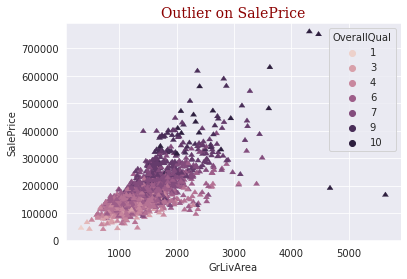

In [ ]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
sns.set_style("darkgrid")
sns.scatterplot(data = traindf, x = "GrLivArea", y= "SalePrice", hue = "OverallQual", marker = 10)
plt.title("Outlier on SalePrice", fontdict = {'family': 'serif','color':  'darkred', 'weight': 'normal','size': 14,})
plt.xlabel("GrLivArea")
plt.ylabel("SalePrice")
plt.show()

traindf = traindf[traindf.GrLivArea < 4000]

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


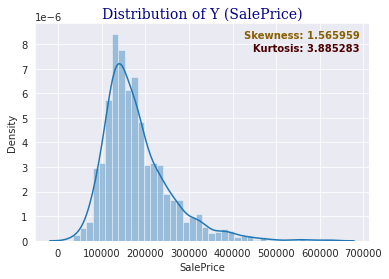

In [ ]:
#heavily right tailed, skewness > 1.5
sns.distplot(traindf.SalePrice)
ax = plt.gca()
ax.text(x=0.97, y=0.97, transform=ax.transAxes, s="Skewness: %f" % traindf.SalePrice.skew(),\
      fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
      color='xkcd:poo brown')
ax.text(x=0.97, y=0.91, transform=ax.transAxes, s="Kurtosis: %f" % traindf.SalePrice.kurt(),\
      fontweight='demibold', fontsize=10, verticalalignment='top', horizontalalignment='right',\
      color='xkcd:dried blood')
plt.title("Distribution of Y (SalePrice)", fontdict = {'family': 'serif','color':  'Darkblue', 'weight': 'normal','size': 14,})
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


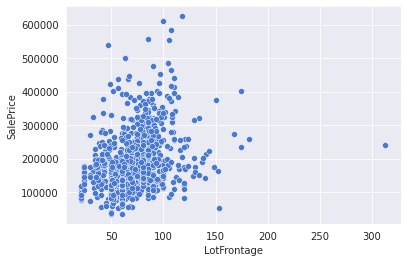

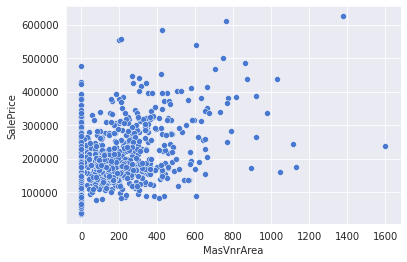

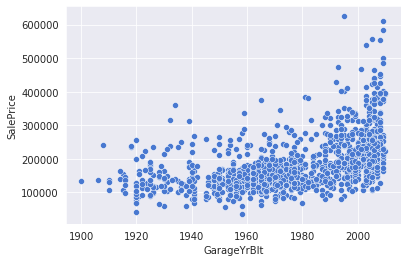

In [ ]:
df = traindf
for col in num_cols:
  plt.figure()
  sns.scatterplot(df[col], df['SalePrice'])
  plt.plot()

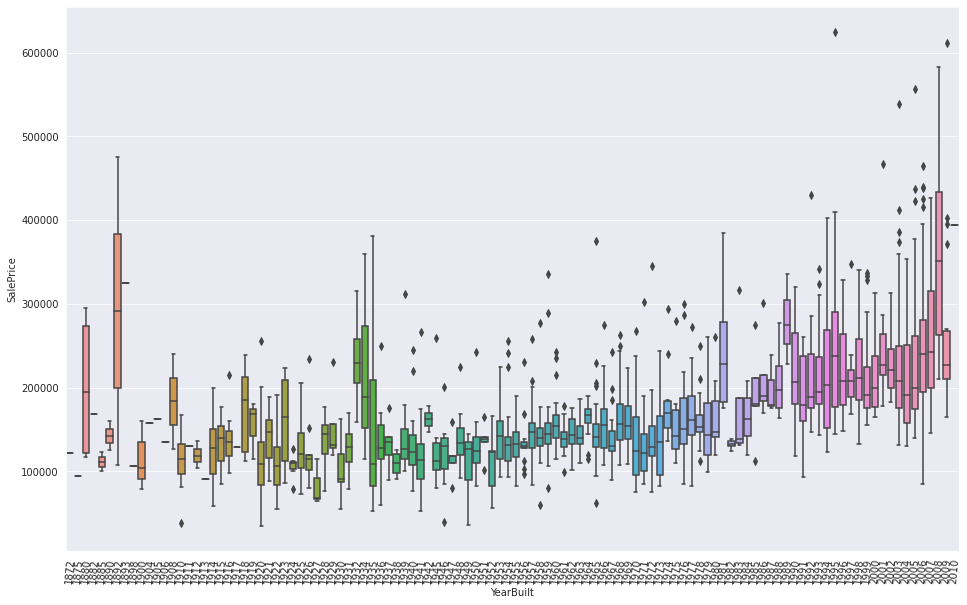

In [ ]:
# yearBuilt needs reengineer
plt.figure(figsize=(16, 10))
sns.boxplot(x= 'YearBuilt', y="SalePrice", data=traindf)
plt.xticks(rotation=85);
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warnin

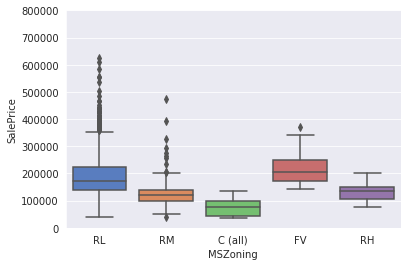

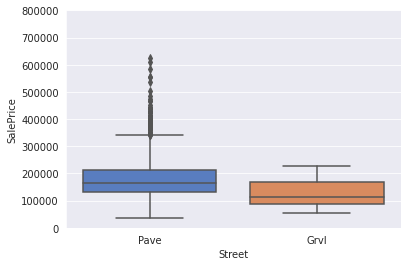

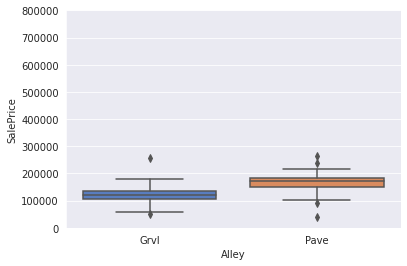

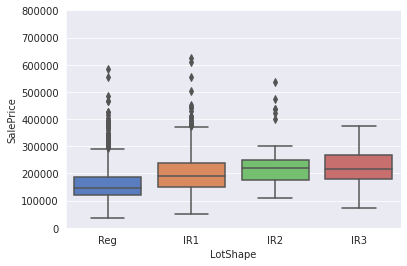

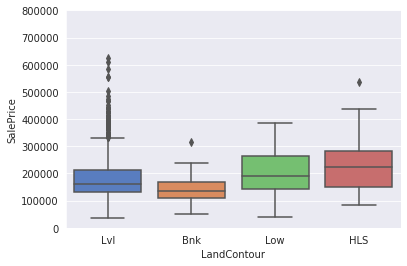

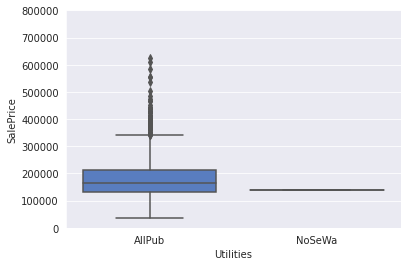

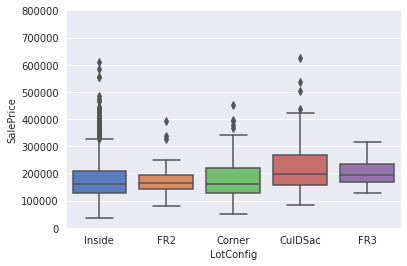

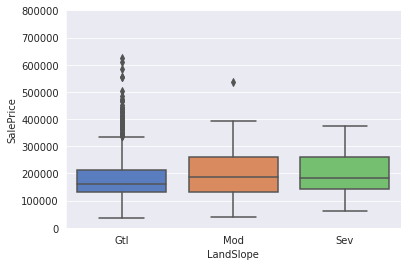

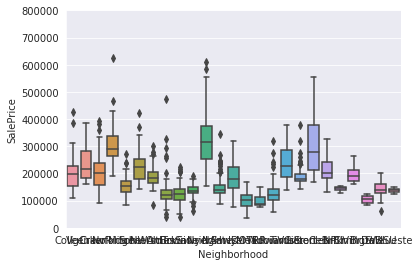

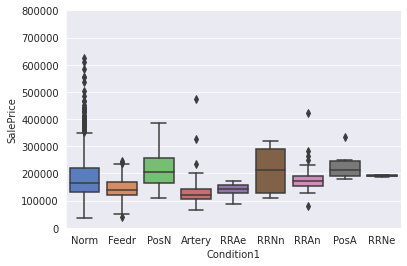

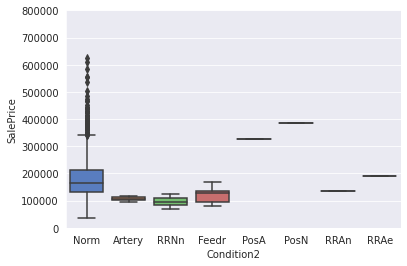

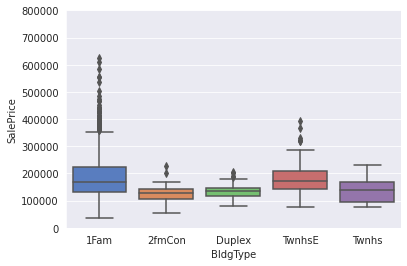

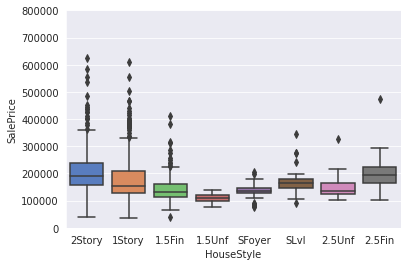

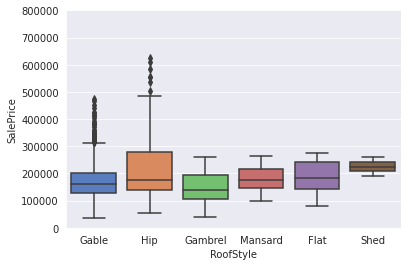

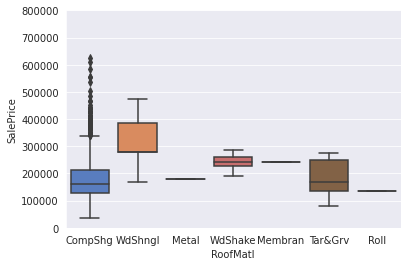

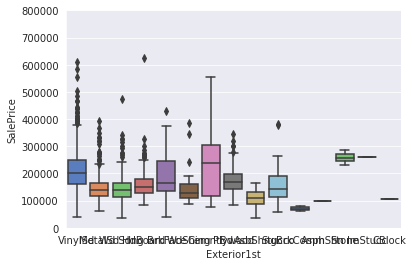

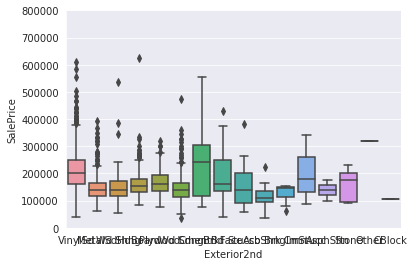

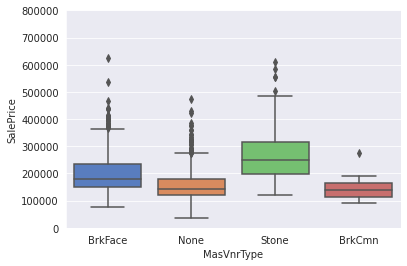

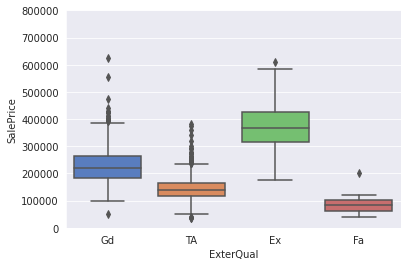

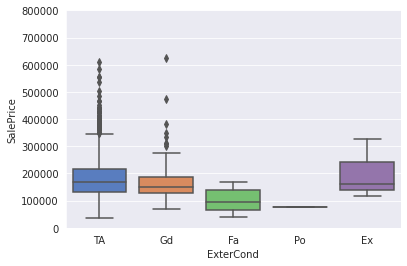

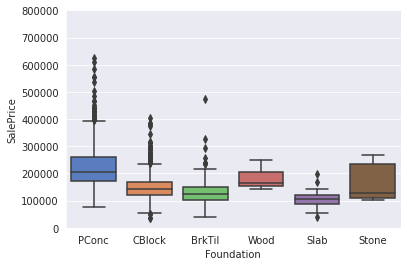

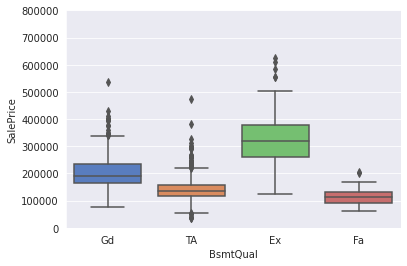

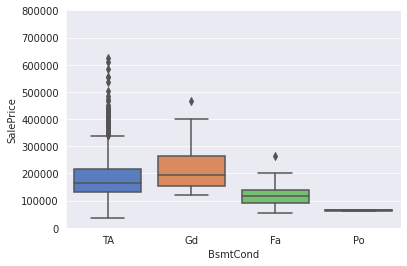

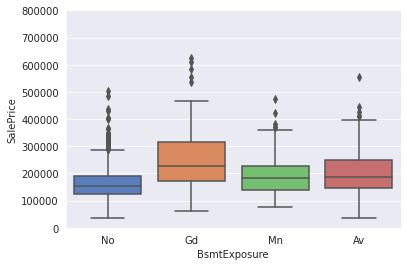

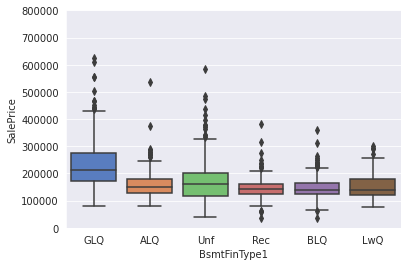

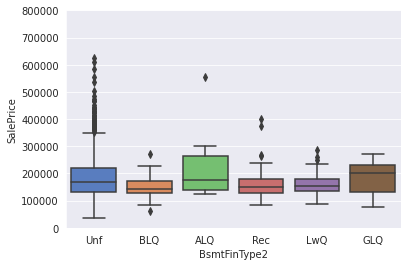

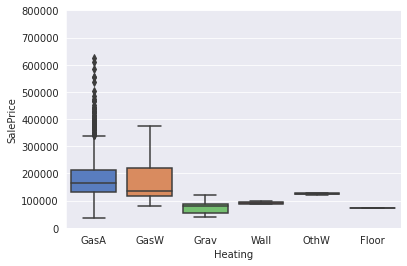

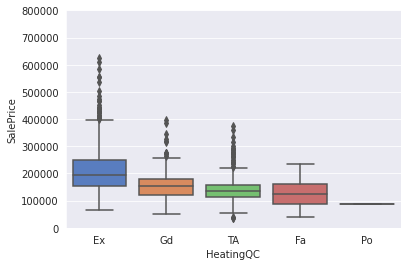

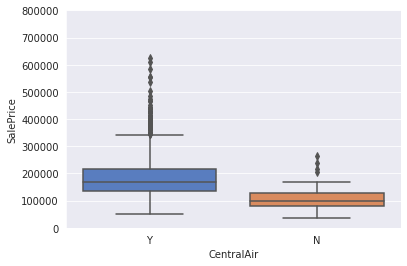

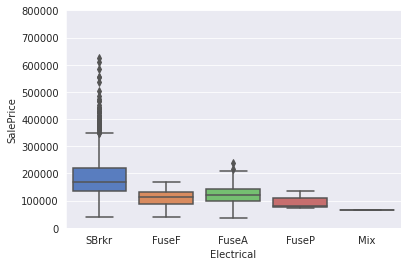

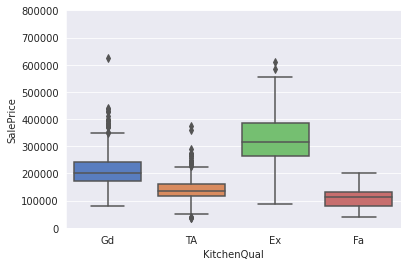

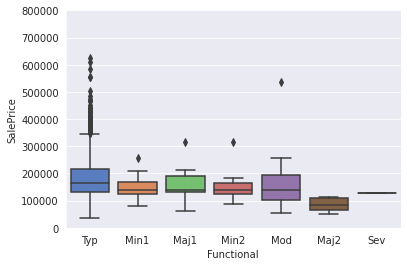

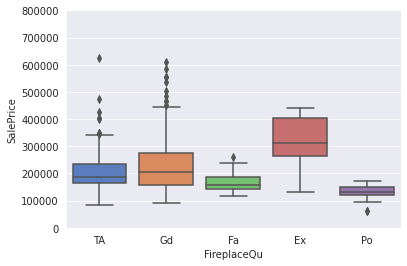

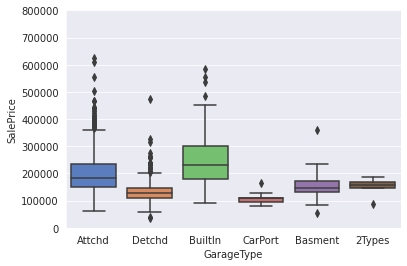

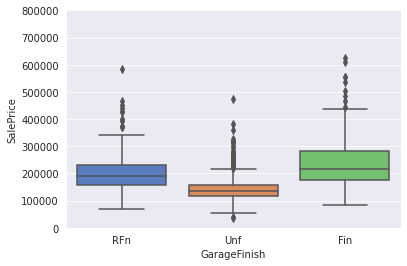

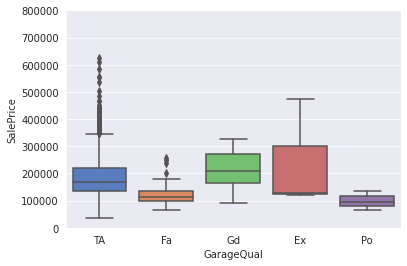

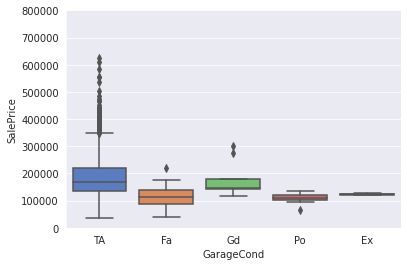

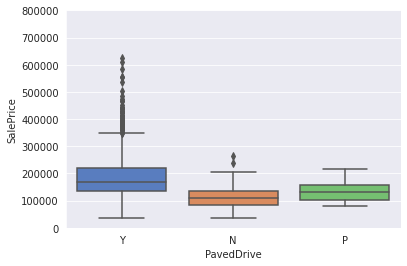

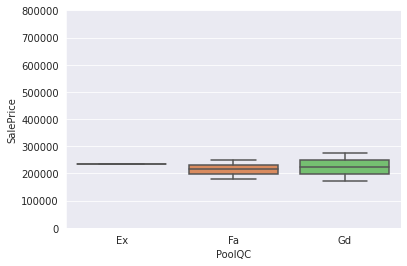

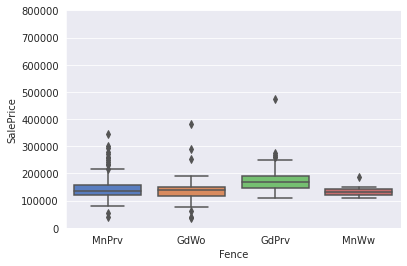

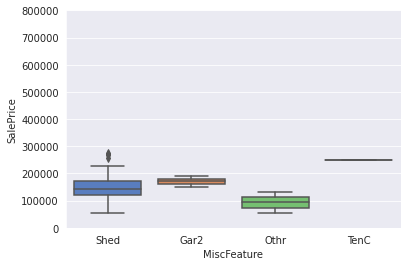

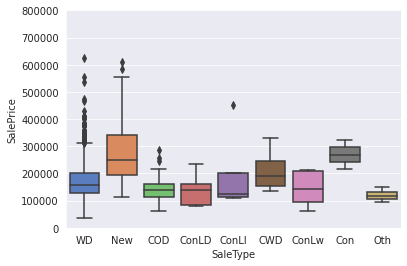

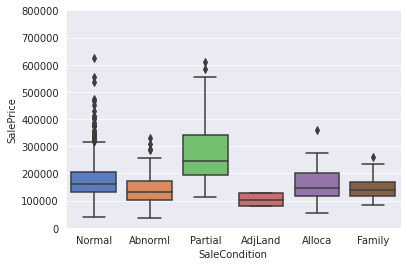

In [ ]:
for col in cate_cols:
  plt.figure()
  ax = plt.gca()
  sns.boxplot(x=col, y="SalePrice", data=traindf)
  ax.set_ylim([0, 800000])
  plt.plot()

In [ ]:
#missing data
na_per_col = traindf.isnull().sum().sort_values(ascending=False)
miss_ratio = (traindf.isnull().sum()/traindf.shape[0]).sort_values(ascending=False)
na_info = pd.concat([na_per_col, miss_ratio], axis=1, keys=['Count', 'Percent'])
na_info.head(21)

,Count,Percent
PoolQC,1451,0.996566
MiscFeature,1402,0.962912
Alley,1365,0.937500
Fence,1176,0.807692
FireplaceQu,690,0.473901
LotFrontage,259,0.177885
GarageCond,81,0.055632
GarageType,81,0.055632
GarageYrBlt,81,0.055632
GarageFinish,81,0.055632


### Imputation

In [ ]:
from collections import Counter

In [ ]:
from tensorflow.keras.utils import to_categorical

In [ ]:
for col in na_info.index[:19]:
  if col in ["GarageYrBlt", "MasVnrArea", "BsmtQual"]:
    traindf[col].fillna(0, inplace = True)
  
  elif col == "LotFrontage":
    #As lot size should be similar for all houses in the same neighborhood, we will use the median for substitute for
    traindf["LotFrontage"] = traindf.groupby("Neighborhood")["LotFrontage"].transform(\
    lambda x: x.fillna(x.median()))
  elif col in ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']:
    traindf[col] = traindf[col].fillna(traindf[col].mode()[0])
  
  elif col == "Functional":
    traindf["Functional"] = traindf["Functional"].fillna("Typ")

  else:
    traindf[col].fillna("None", inplace = True)

sum(traindf.isnull().sum() != 0) # should be 0 if all imputed

0

In [ ]:
vals_per_col = traindf.iloc[:1].copy()
for col in traindf.columns:
  if len(traindf[col].drop_duplicates()) < 11:
    vals_per_col[col] = [traindf[col].drop_duplicates().tolist()]
  else:
    vals_per_col[col] = len(traindf[col].drop_duplicates())
vals_per_col

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1456,15,"[RL, RM, C (all), FV, RH]",114,1069,"[Pave, Grvl]","[None, Grvl, Pave]","[Reg, IR1, IR2, IR3]","[Lvl, Bnk, Low, HLS]","[AllPub, NoSeWa]","[Inside, FR2, Corner, CulDSac, FR3]","[Gtl, Mod, Sev]",25,"[Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ...","[Norm, Artery, RRNn, Feedr, PosA, PosN, RRAn, ...","[1Fam, 2fmCon, Duplex, TwnhsE, Twnhs]","[2Story, 1Story, 1.5Fin, 1.5Unf, SFoyer, SLvl,...","[7, 6, 8, 5, 9, 4, 10, 3, 1, 2]","[5, 8, 6, 7, 4, 2, 3, 9, 1]",112,61,"[Gable, Hip, Gambrel, Mansard, Flat, Shed]","[CompShg, WdShngl, Metal, WdShake, Membran, Ta...",15,16,"[BrkFace, None, Stone, BrkCmn]",324,"[Gd, TA, Ex, Fa]","[TA, Gd, Fa, Po, Ex]","[PConc, CBlock, BrkTil, Wood, Slab, Stone]","[Gd, TA, Ex, 0, Fa]","[TA, Gd, None, Fa, Po]","[No, Gd, Mn, Av, None]","[GLQ, ALQ, Unf, Rec, BLQ, None, LwQ]",633,"[Unf, BLQ, None, ALQ, Rec, LwQ, GLQ]",144,779,717,"[GasA, GasW, Grav, Wall, OthW, Floor]",...,"[Y, N]","[SBrkr, FuseF, FuseA, FuseP, Mix]",749,413,24,857,"[1, 0, 2, 3]","[0, 1, 2]","[2, 1, 3, 0]","[1, 0, 2]","[3, 4, 1, 2, 0, 5, 6, 8]","[1, 2, 3, 0]","[Gd, TA, Ex, Fa]",12,"[Typ, Min1, Maj1, Min2, Mod, Maj2, Sev]","[0, 1, 2, 3]","[None, TA, Gd, Fa, Ex, Po]","[Attchd, Detchd, BuiltIn, CarPort, None, Basme...",98,"[RFn, Unf, Fin, None]","[2, 3, 1, 0, 4]",438,"[TA, Fa, Gd, None, Ex, Po]","[TA, Fa, None, Gd, Po, Ex]","[Y, N, P]",274,200,120,20,76,"[0, 512, 648, 576, 519, 738]","[None, Ex, Fa, Gd]","[None, MnPrv, GdWo, GdPrv, MnWw]","[None, Shed, Gar2, Othr, TenC]",21,12,"[2008, 2007, 2006, 2009, 2010]","[WD, New, COD, ConLD, ConLI, CWD, ConLw, Con, ...","[Normal, Abnorml, Partial, AdjLand, Alloca, Fa...",660


#### Feature engineering

In [ ]:
# switch to cate for num cols that are in fact YES/NO binary attributes 
for col in int_cols:
  if len(traindf[col].drop_duplicates()) == 2:
    print(col, "binary attribute, switching -> categorical for YES/NO")
    del int_cols[col]
    cate_cols.append(col)

In [ ]:
# numerical columns that are actually categorical
traindf = traindf.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
                       "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
                                   7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
                      })

In [ ]:
# Cate -> ordinal for those that have inherent order meanings
poor_to_excellent = {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5}

# method 1 -> NA as lowest
traindf = traindf.replace({"Alley" : {'None': 0, "Grvl" : 1, "Pave" : 2},
                       "BsmtCond" : poor_to_excellent,
                       "BsmtExposure" : {"None" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : poor_to_excellent,
                       "ExterCond" : poor_to_excellent,
                       "ExterQual" : poor_to_excellent,
                       "FireplaceQu" : poor_to_excellent,
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : poor_to_excellent,
                       "GarageQual" : poor_to_excellent,
                       "HeatingQC" : poor_to_excellent,
                       "KitchenQual" : poor_to_excellent,
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )
 
#  # method 2 -> NA as mid-valued for some
#  poor_to_excellent = {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5}
#  none_is_norm = {"Po" : 0, "Fa" : 1, "None" : 2, "TA": 3, "Gd" : 4, "Ex" : 5}
#  traindf = traindf.replace({"Alley" : {'None': 0, "Grvl" : 1, "Pave" : 2},
#                        "BsmtCond" : poor_to_excellent,
#                        "BsmtExposure" : {"None" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
#                        "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
#                                          "ALQ" : 5, "GLQ" : 6},
#                        "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
#                                          "ALQ" : 5, "GLQ" : 6},
#                        "BsmtQual" : poor_to_excellent,
#                        "ExterCond" : poor_to_excellent,
#                        "ExterQual" : poor_to_excellent,
#                        "FireplaceQu" : poor_to_excellent,
#                        "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
#                                        "Min2" : 6, "Min1" : 7, "Typ" : 8},
#                        "GarageCond" : poor_to_excellent,
#                        "GarageQual" : poor_to_excellent,
#                        "HeatingQC" : poor_to_excellent,
#                        "KitchenQual" : {poor_to_excellent,
#                        "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
#                        "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
#                        "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
#                        "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
#                        "Street" : {"Grvl" : 1, "Pave" : 2},
#                        "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
#                      )

In [ ]:
# Drop levels in feature to simplify
tri_for_ten = {1 : 1, 2 : 1, 3 : 1, # bad
 4 : 2, 5 : 2, 6 : 2, # average
7 : 3, 8 : 3, 9 : 3, 10 : 3} # good
avg_gd_bad_five = {1 : 1, # bad 
                   2 : 2, 3 : 2, # average
                   4 : 3, 5 : 3} # good

traindf["S_OverallQual"] = traindf.OverallQual.replace(tri_for_ten)
traindf["S_OverallCond"] = traindf.OverallCond.replace(tri_for_ten)
traindf["S_PoolQC"] = traindf.PoolQC.replace({1 : 1, 2 : 1, # average
                                             3 : 2, 4 : 2 # good
                                            })
traindf["S_GarageCond"] = traindf.GarageCond.replace(avg_gd_bad_five)
traindf["S_GarageQual"] = traindf.GarageQual.replace(avg_gd_bad_five)
traindf["S_FireplaceQu"] = traindf.FireplaceQu.replace(avg_gd_bad_five)
traindf["S_FireplaceQu"] = traindf.FireplaceQu.replace(avg_gd_bad_five)
traindf["S_Functional"] = traindf.Functional.replace({1 : 1, 2 : 1, # bad
                                                     3 : 2, 4 : 2, # major issue
                                                     5 : 3, 6 : 3, 7 : 3, # minor issue
                                                     8 : 4 # typical
                                                    })
traindf["S_KitchenQual"] = traindf.KitchenQual.replace(avg_gd_bad_five)
traindf["S_HeatingQC"] = traindf.HeatingQC.replace(avg_gd_bad_five)
traindf["S_BsmtFinType1"] = traindf.BsmtFinType1.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
traindf["S_BsmtFinType2"] = traindf.BsmtFinType2.replace({1 : 1, # unfinished
                                                         2 : 1, 3 : 1, # rec room
                                                         4 : 2, 5 : 2, 6 : 2 # living quarters
                                                        })
traindf["S_BsmtCond"] = traindf.BsmtCond.replace(avg_gd_bad_five)
traindf["S_BsmtQual"] = traindf.BsmtQual.replace(avg_gd_bad_five)
traindf["S_ExterCond"] = traindf.ExterCond.replace(avg_gd_bad_five)
traindf["S_ExterQual"] = traindf.ExterQual.replace(avg_gd_bad_five)



In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
# Combine for "department" Grade
# ============ Original ============ #
# Overall quality of the house
traindf["OverallScore"] = traindf["OverallQual"] * traindf["OverallCond"]

# Overall quality of the garage
traindf["GarageScore"] = traindf["GarageQual"] * traindf["GarageCond"]
# Overall quality of the exterior
traindf["ExterGrade"] = traindf["ExterQual"] * traindf["ExterCond"]
# Overall kitchen Grade
traindf["KitchenGrade"] = traindf["KitchenAbvGr"] * traindf["KitchenQual"]
# Overall fireplace Grade
traindf["FireplaceGrade"] = traindf["Fireplaces"] * traindf["FireplaceQu"]
# Overall garage Grade
traindf["GarageGrade"] = traindf["GarageArea"] * traindf["GarageQual"]
# Overall pool Grade
traindf["PoolGrade"] = traindf["PoolArea"] * traindf["PoolQC"]

cols = ["OverallScore", "GarageScore", "ExterGrade", "KitchenGrade", "FireplaceGrade", "GarageGrade", "PoolGrade"]
traindf[cols] = scaler.fit_transform(traindf[cols])
# ============ Simplified ============ #
# Simplified overall quality of the house
traindf["S_OverallScore"] = traindf["S_OverallQual"] * traindf["S_OverallCond"]

# Simplified overall garage Grade
traindf["S_GarageGrade"] = traindf["GarageArea"] * traindf["S_GarageQual"]
# Simplified overall quality of the exterior
traindf["S_ExterGrade"] = traindf["S_ExterQual"] * traindf["S_ExterCond"]
# Simplified overall kitchen Grade
traindf["S_KitchenGrade"] = traindf["KitchenAbvGr"] * traindf["S_KitchenQual"]
# Simplified overall fireplace Grade
traindf["S_FireplaceGrade"] = traindf["Fireplaces"] * traindf["S_FireplaceQu"]
# Simplified overall pool Grade
traindf["S_PoolGrade"] = traindf["PoolArea"] * traindf["S_PoolQC"]

cols = ["S_OverallScore", "S_GarageGrade", "S_ExterGrade", "S_KitchenGrade", "S_FireplaceGrade", "S_GarageGrade", "S_PoolGrade"]
traindf[cols] = scaler.fit_transform(traindf[cols])

# ============ Custom ============ #
# Total number of bathrooms
traindf["TotalBath"] = traindf["BsmtFullBath"] + (0.5 * traindf["BsmtHalfBath"]) + \
traindf["FullBath"] + (0.5 * traindf["HalfBath"])
# Total SF for house (incl. basement)
traindf["TotalSF"] = traindf["1stFlrSF"] + traindf["2ndFlrSF"] + traindf["TotalBsmtSF"]
# Total SF for 1st + 2nd floors
traindf["AllFlrsSF"] = traindf["1stFlrSF"] + traindf["2ndFlrSF"]
# Total SF for porch
traindf["AllPorchSF"] = traindf["OpenPorchSF"] + traindf["EnclosedPorch"] + \
traindf["3SsnPorch"] + traindf["ScreenPorch"]
# Has masonry veneer or not
traindf["HasMasVnr"] = traindf.MasVnrType.replace({"BrkCmn" : 0, "BrkFace" : 1,
                                               "Stone" : 2, "None" : 0})
# House completed before sale or not
traindf["PurchaseType"] = traindf.SaleCondition.replace({"Abnorml" : 1, "Alloca" : 2, "AdjLand" : 0, 
                                                      "Family" : 1, "Normal" : 2, "Partial" : 3})



In [ ]:
my_clrs = sns.color_palette("muted", 15) #good for lighter background
sns.set_palette("muted", 15) #good for lighter background

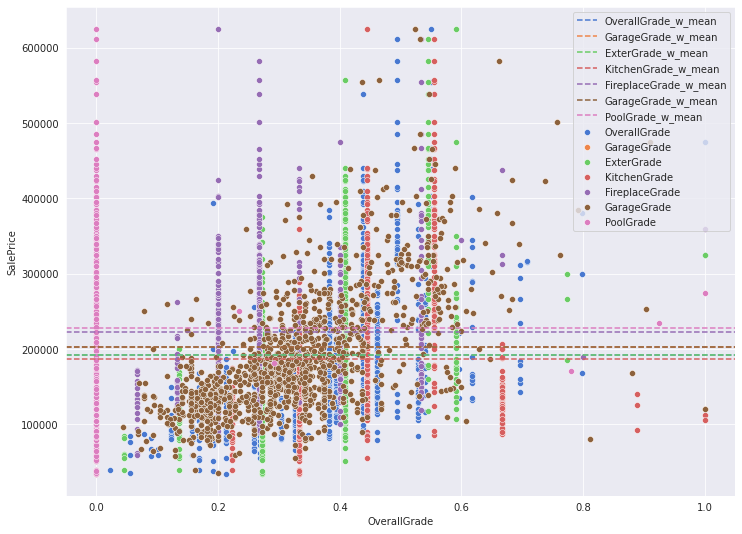

In [ ]:
#num couple similar categories
#sns.set_palette("pastel")
with sns.axes_style("darkgrid"):
  my_cols = ["OverallScore", "GarageGrade", "ExterGrade", "KitchenGrade", "FireplaceGrade", "GarageGrade", "PoolGrade"]
  plt.figure(figsize=(12, 9))
  for i,col in enumerate(my_cols):
    graph = sns.scatterplot(x = traindf[col], y = traindf['SalePrice'], label = col)
    #draw horiz for mean price
    w_mean = (traindf[col] * traindf['SalePrice'] / traindf[col].mean()).mean()
    graph.axhline(w_mean, label = col + '_w_mean',ls = "--", c = my_clrs[i])
  plt.legend()
  plt.plot()

  # pool and fireplace grades the most significant

[]

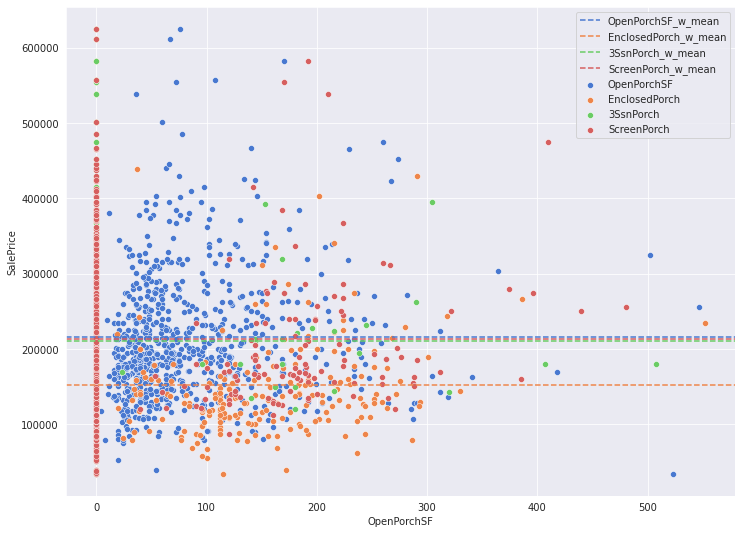

In [ ]:
#numerical, weight mean in each categories
#sns.set_palette("pastel")
my_cols = ["OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"]
plt.figure(figsize=(12, 9))
for i,col in enumerate(my_cols):
  graph = sns.scatterplot(x = traindf[col], y = traindf['SalePrice'], label = col)
  #draw horiz for mean price
  w_mean = (traindf[col] * traindf['SalePrice'] / traindf[col].mean()).mean()
  graph.axhline(w_mean, label = col + '_w_mean',ls = "--", c = my_clrs[i])
plt.legend()
plt.plot()

#encls porch diff than others more significantly

[]

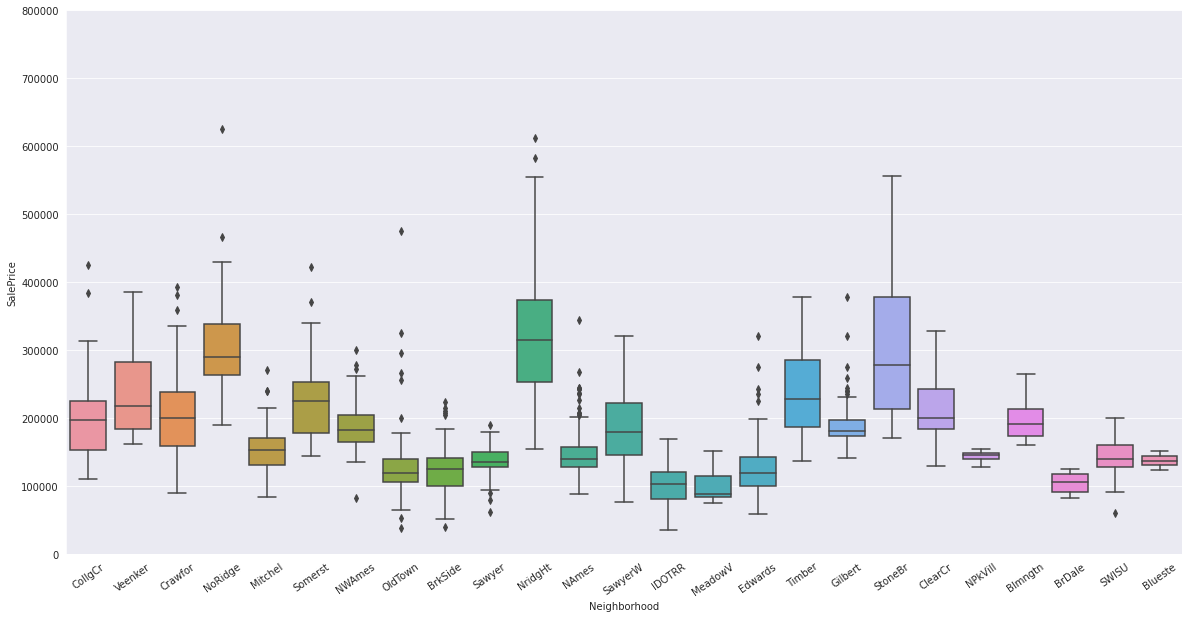

In [ ]:
# helpful viz for deciding encoding for categorical features
plt.figure(figsize=(20, 10))
col = 'Neighborhood'
ax = plt.gca()
sns.boxplot(x=col, y="SalePrice", data=traindf)
ax.set_ylim([0, 800000])
plt.xticks(rotation=35);
plt.plot()

[]

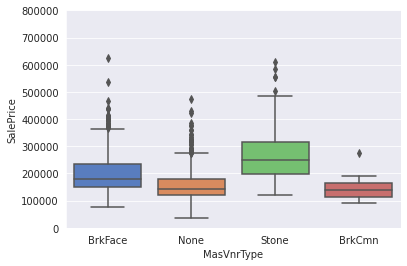

In [ ]:
# helpful viz for deciding encoding for categorical features
col = 'MasVnrType'
plt.figure()
ax = plt.gca()
sns.boxplot(x=col, y="SalePrice", data=traindf)
ax.set_ylim([0, 800000])
plt.plot()

#### check for normality

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


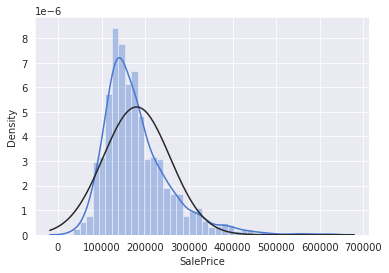

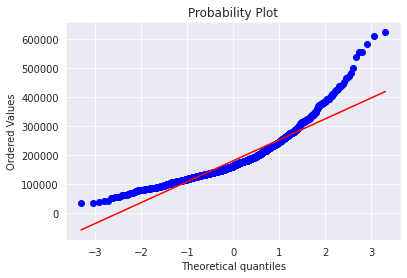

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


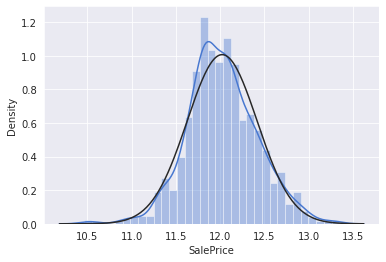

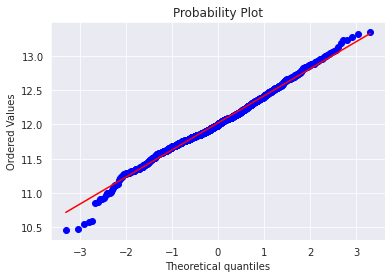

In [ ]:
#histogram and normal probability plot
sns.distplot(traindf['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(traindf['SalePrice'], plot=plt)
plt.show()
#histogram and normal probability plot
sns.distplot(np.log(traindf['SalePrice']), fit=norm);
fig = plt.figure()
res = stats.probplot(np.log(traindf['SalePrice']), plot=plt)
plt.show()

In [ ]:
traindf["New_Price"] = np.log(traindf["SalePrice"])

In [ ]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = traindf.corr()
corr.sort_values(["New_Price"], ascending = False, inplace = True)
print(corr.New_Price)

to_look_cols = corr.New_Price[corr.New_Price > 0.5].index[2:].tolist() #skip newprice and saleprice

Find most important features relative to target
New_Price        1.000000
SalePrice        0.954609
TotalSF          0.822028
OverallQual      0.819240
AllSF            0.817272
                   ...   
LandSlope       -0.040113
Alley           -0.090759
KitchenAbvGr    -0.147890
EnclosedPorch   -0.148636
LotShape        -0.285903
Name: New_Price, Length: 91, dtype: float64


In [ ]:
#for iterating and checking if we should remove columns that are collinear
col = to_look_cols[0]
to_look_cols.remove("S_OverallQual")
to_look_cols.remove("AllFlrsSF") #AllSF
to_look_cols.remove("GrLivArea") #AllFlrsSF 

to_look_cols.remove("GarageCars") #GarageGrade
to_look_cols.remove("S_GarageGrade") #GarageGrade
to_look_cols.remove("S_ExterQual") #ExterQual
to_look_cols.remove("S_KitchenQual") #KitchenQual 
to_look_cols.remove("S_BsmtQual") #BsmtQual 
to_look_cols.remove("S_ExterGrade") #ExterGrade
to_look_cols.remove("S_FireplaceQu") #FireplaceQu
to_look_cols.remove("FireplaceQu") #FireplaceGrade 
to_look_cols.remove("S_FireplaceGrade") #FireplaceGrade
to_look_cols.remove("S_OverallScore") #OverallScore



corr = traindf[to_look_cols].corr()
corr.sort_values([col], ascending = False, inplace = True)
print(f"checking {col}", corr[col])


checking TotalSF TotalSF           1.000000
AllSF             0.997949
TotalBsmtSF       0.804298
1stFlrSF          0.778623
TotRmsAbvGrd      0.678634
OverallQual       0.673690
TotalBath         0.603883
FullBath          0.589905
GarageCars        0.560434
ExterQual         0.532357
BsmtQual          0.524308
KitchenQual       0.502313
FireplaceGrade    0.499622
ExterScore        0.449253
OverallScore      0.426577
YearBuilt         0.355324
YearRemodAdd      0.353755
Name: TotalSF, dtype: float64


In [ ]:
num_cols = []
cate_cols = traindf.select_dtypes(include = ["object"]).columns
int_cols = []
all_types = set()
for col, c_type in zip(traindf.dtypes.index, traindf.dtypes):
  all_types.add(c_type)
  if c_type == "int64":
    int_cols.append(col)
  elif c_type == "float64":
    num_cols.append(col)
  else:
    continue #i.e., cate col found

In [ ]:
num_cols = set(to_look_cols).union(set(int_cols).union(num_cols).intersection(to_look_cols))
#found two num cols to log transform

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


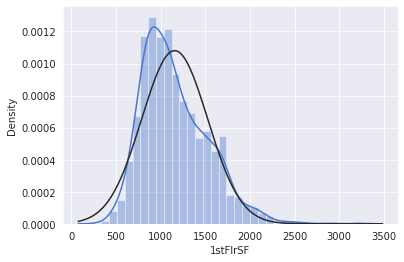

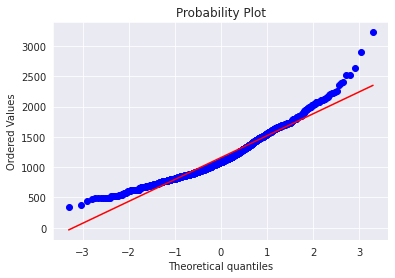

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


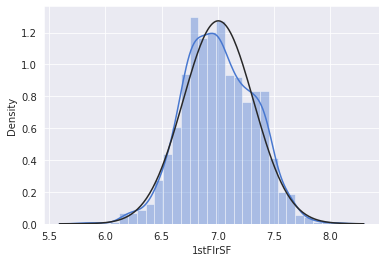

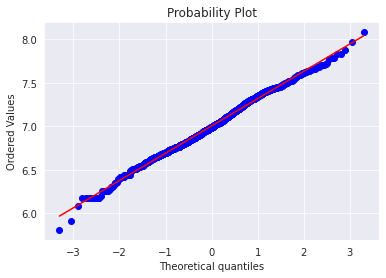

In [ ]:
col = "1stFlrSF" #log transform much better
sns.distplot(traindf[col], fit=norm); #AIISF, AllFlrsSF, 
fig = plt.figure()
res = stats.probplot(traindf[col] + 0.01, plot=plt)
plt.show()
sns.distplot(np.log(traindf[col]), fit=norm); #AIISF, AllFlrsSF, 
fig = plt.figure()
res = stats.probplot(np.log(traindf[col] + 0.01), plot=plt)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


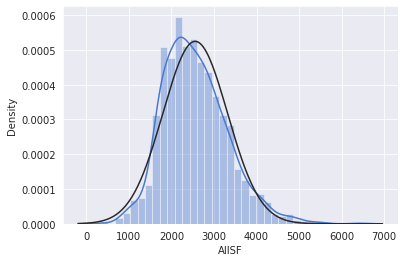

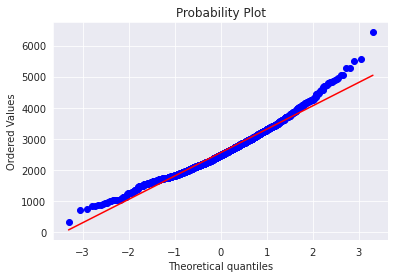

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


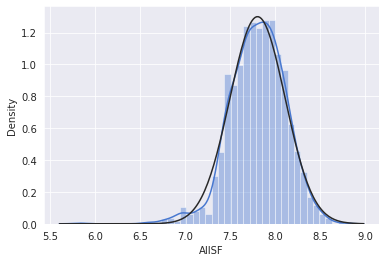

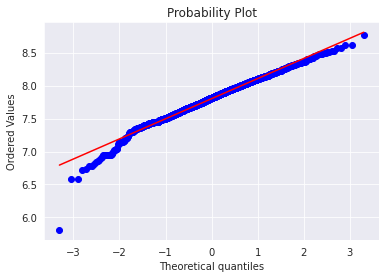

In [ ]:
# optional for log transformation
col = "AllSF"
sns.distplot(traindf[col] + 1, fit=norm); #AIISF, AllFlrsSF, 
fig = plt.figure()
res = stats.probplot(traindf[col] + 0.01, plot=plt)
plt.show()
sns.distplot(np.log(traindf[col] + 1), fit=norm); #AIISF, AllFlrsSF, 
fig = plt.figure()
res = stats.probplot(np.log(traindf[col] + 0.01), plot=plt)
plt.show()

In [ ]:
if "1stFlrSF" in num_cols:
  traindf['1stFlrSF'] = np.log(traindf["1stFlrSF"])


In [ ]:
train_num = traindf[num_cols]
train_cat = traindf[cate_cols]

In [ ]:
scaler = MinMaxScaler()
for col in train_num.columns:
  train_num.loc[:, col] = scaler.fit_transform(train_num.loc[:, col][:, np.newaxis]).ravel()
train_num

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel pack

,TotalBath,OverallQual,TotRmsAbvGrd,KitchenQual,OverallGrade,1stFlrSF,TotalBsmtSF,YearRemodAdd,GarageCars,ExterQual,FireplaceGrade,YearBuilt,FullBath,ExterGrade,BsmtQual,AllSF
0,0.5,0.666667,0.500000,0.666667,0.382022,0.180373,0.266999,0.883333,0.50,0.666667,0.000000,0.949275,0.666667,0.409091,0.8,0.366262
1,0.3,0.555556,0.333333,0.333333,0.528090,0.320663,0.393637,0.433333,0.50,0.333333,0.200000,0.753623,0.666667,0.272727,0.8,0.359370
2,0.5,0.666667,0.333333,0.666667,0.382022,0.202488,0.286962,0.866667,0.50,0.666667,0.200000,0.934783,0.666667,0.409091,0.8,0.389235
3,0.2,0.666667,0.416667,0.666667,0.382022,0.216655,0.235808,0.333333,0.75,0.333333,0.266667,0.311594,0.333333,0.272727,0.6,0.351001
4,0.5,0.777778,0.583333,0.666667,0.438202,0.280235,0.357143,0.833333,0.75,0.666667,0.200000,0.927536,0.666667,0.409091,0.8,0.493764
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,0.3,0.555556,0.416667,0.333333,0.325843,0.213891,0.297255,0.833333,0.50,0.333333,0.200000,0.920290,0.666667,0.272727,0.8,0.371841
1456,0.4,0.555556,0.416667,0.333333,0.393258,0.600898,0.480973,0.633333,0.50,0.333333,0.400000,0.768116,0.666667,0.272727,0.8,0.538398
1457,0.2,0.666667,0.583333,0.666667,0.696629,0.295093,0.359326,0.933333,0.25,1.000000,0.533333,0.500000,0.666667,0.772727,0.6,0.518215
1458,0.2,0.444444,0.250000,0.666667,0.325843,0.257084,0.336245,0.766667,0.25,0.333333,0.000000,0.565217,0.333333,0.272727,0.6,0.298983


In [ ]:
print(train_cat.shape)
train_cat = pd.get_dummies(train_cat)
train_cat.shape

(1456, 26)


(1456, 204)

In [ ]:
# Join categorical and numerical features
train = pd.concat([train_num, train_cat], axis = 1)
print("New number of features : " + str(train.shape[1]))
y = traindf["New_Price"]

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

New number of features : 221
X_train : (1019, 221)
X_test : (437, 221)
y_train : (1019,)
y_test : (437,)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
clf = RandomForestRegressor(max_depth=3, min_samples_split = 30, random_state=0)
clf.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=3, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=30, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [ ]:
imprt_feats = X_train.columns[np.argsort(clf.feature_importances_)[::-1]]


In [ ]:
result = permutation_importance(clf, X_train, y_train, n_repeats=10,
                                 random_state=0)


[]

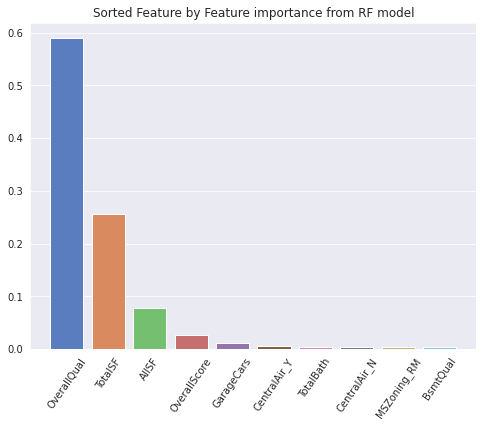

In [ ]:
plt.figure(figsize = [8,6])
top_k = 10
sns.barplot(x=imprt_feats[:top_k], y= np.sort(clf.feature_importances_)[::-1][:top_k])
plt.xticks(rotation = 55)
plt.title("Sorted Feature by Feature importance from RF model")
plt.plot()

In [ ]:
mod_X_train = X_train.copy()
mod_y_train = y_train.copy()

In [ ]:
mod_X_train.drop(columns = ["OverallQual", "TotalSF", "AllSF"], inplace= True)
mod_y_train.drop(columns = ["OverallQual", "TotalSF", "AllSF"], inplace= True)

[('AllSF', 0.680945283244698), ('ExterQual', 0.06997879446385827)]
[('YearBuilt', 0.11445814848674969), ('OverallScore', 0.10644139536171275)]
[('KitchenQual', 0.19140309840861075), ('GarageCars', 0.1323936611385862)]
[('BsmtQual', 0.23023585244508635), ('FireplaceGrade', 0.08594784926350202)]


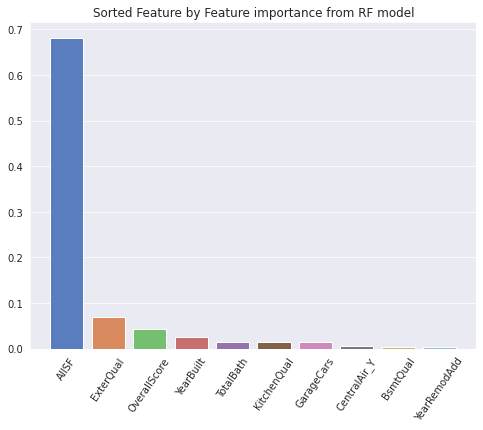

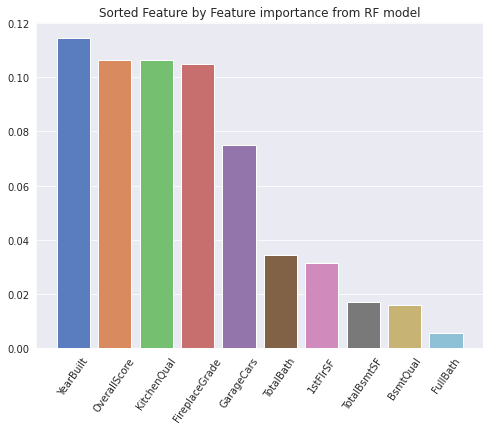

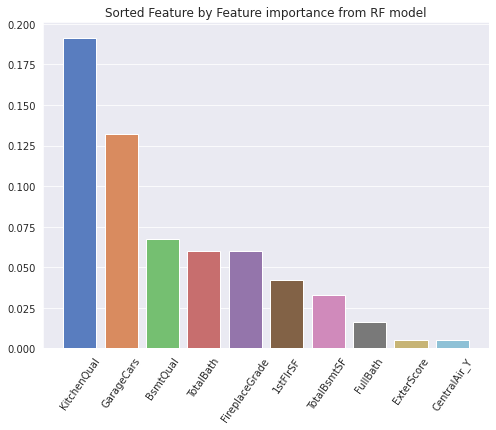

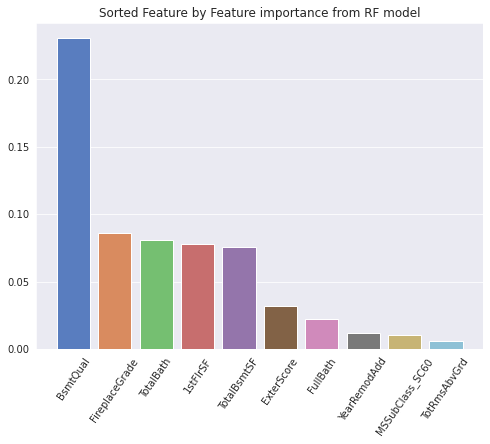

In [ ]:
best_ones = ["OverallQual", "TotalSF"]
for i in range(4):
  clf = RandomForestRegressor(max_depth=3, min_samples_split = 30, random_state=0)
  clf.fit(mod_X_train, mod_y_train)
  result = permutation_importance(clf, mod_X_train, mod_y_train, n_repeats=10,
                                  random_state=0)

  plt.figure(figsize = [8,6])
  top_k = 10
  #sns.barplot(x=imprt_feats[:top_k], y= np.sort(clf.feature_importances_)[::-1][:top_k])
  imprt_feats = mod_X_train.columns[np.argsort(result.importances_mean)[::-1]]
  scores = np.sort(result.importances_mean)[::-1]
  sns.barplot(x=imprt_feats[:top_k], y= scores[:top_k])
  plt.xticks(rotation = 55)
  plt.title("Sorted Feature by Feature importance from RF model")
  plt.plot()

  to_drop = imprt_feats[:2].tolist()
  best_ones += to_drop
  print(list(zip(to_drop, scores[:2])))
  mod_X_train.drop(columns = to_drop, inplace= True)
  mod_y_train.drop(columns = to_drop, inplace= True)

In [ ]:
print(best_ones)

['OverallQual', 'TotalSF', 'ExterQual', 'YearBuilt', 'OverallScore', 'KitchenQual', 'GarageCars', 'BsmtQual']


#### Hyper-param tuning for RF regressor

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)
{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train[best_ones], y_train)


{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100,
                              

In [ ]:
print(rf_random.best_params_)
pred = rf_random.best_estimator_.predict(X_test[best_ones])
np.sqrt(np.mean((pred - y_test) ** 2))

{'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': True}


0.1292248343728242

In [ ]:
# Fit on whole data
# After custom testing
# Need small min sampls to inc test perf
# max depth must be > 20
# max feature best to be sqrt
clf = RandomForestRegressor(n_estimators = 300, max_depth=30, min_samples_split = 5, 
                            bootstrap = True, min_samples_leaf = 1, 
                            max_features = "sqrt", random_state=0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
np.sqrt(np.mean((pred - y_test) ** 2))

0.12446434688661423

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [30, 60, 90, 120],
    'max_features': [2, 3, "sqrt"],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [5, 10, 15],
    'n_estimators': [200, 400, 800]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

# Fit the grid search to the data
grid_search.fit(X_train[best_ones], y_train)
grid_search.best_params_
{'bootstrap': True,
 'max_depth': 80,
 'max_features': 3,
 'min_samples_leaf': 5,
 'min_samples_split': 12,
 'n_estimators': 100}
best_grid = grid_search.best_estimator_
pred = grid_search.best_estimator_.predict(X_test[best_ones])
np.sqrt(np.mean((pred - y_test) ** 2))

Fitting 3 folds for each of 324 candidates, totalling 972 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   23.3s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 644 tasks      | elapsed:  6.8min
[Parallel(n_jobs=-1)]: Done 972 out of 972 | elapsed: 10.3min finished


0.13037855357244998

In [ ]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 30,
 'max_features': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 200}

In [ ]:
##### WITH REDUCED FEATURES

# Custom testing here, TOtal SF and OverallScore most; then GarageGrade, YearBuilt, BasmtQual, KitchenQual most important
# surprisingly poolgrade isn't really that impactful under other factors nor alone
# SF outstandingly important, then followed by factors listed in order; 
# only top two features alone gives 0.17 
selected_cols = ["TotalSF", "OverallScore"] + ["GarageCars", "YearBuilt", "BsmtQual", "S_FireplaceGrade", "PoolGrade"]

clf = RandomForestRegressor(n_estimators = 400, max_depth=30, min_samples_split = 5, 
                            bootstrap = True, min_samples_leaf = 1, 
                            max_features = "sqrt", random_state=0)

X_train, X_test, y_train, y_test = train_test_split(traindf[selected_cols], y, test_size = 0.3, random_state = 0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
np.sqrt(np.mean((pred - y_test) ** 2))

0.12878605332765136

In [ ]:
# Custom testing here, TOtal SF and OverallScore most; then GarageGrade, YearBuilt, BasmtQual, KitchenQual most important
# surprisingly poolgrade isn't really that impactful under other factors nor alone
# SF outstandingly important, then followed by factors listed in order; 
# only top two features alone gives 0.17 
selected_cols = ['OverallQual', 'TotalSF', 'S_FireplaceGrade', 'PoolGrade', 'YearBuilt', 'OverallScore','KitchenQual','GarageCars','BsmtQual']

clf = RandomForestRegressor(n_estimators = 400, max_depth=30, min_samples_split = 5, 
                            bootstrap = True, min_samples_leaf = 1, 
                            max_features = "sqrt", random_state=0)

X_train, X_test, y_train, y_test = train_test_split(traindf[selected_cols], y, test_size = 0.3, random_state = 0)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
np.sqrt(np.mean((pred - y_test) ** 2))

0.127847716143803

In [ ]:
if "OverallQual" in best_ones and "OverallScore" in best_ones:
  best_ones.remove("OverallScore")
  print("OverallScore removed")

In [ ]:
set(num_cols).intersection(best_ones) # selected ones that are numerical

{'BsmtQual',
 'ExterQual',
 'FireplaceGrade',
 'GarageCars',
 'KitchenQual',
 'OverallQual',
 'OverallScore',
 'TotalSF',
 'YearBuilt'}

#### Categorical column selections

In [ ]:
# Ordinal encoding
train_cat = traindf[cate_cols]
X_train_cat = train_cat.copy()
for col in train_cat:
  X_train_cat[col] = train_cat[col].astype('category').cat.codes
X_train_cat, X_test_cat = train_test_split(X_train_cat, test_size = 0.3)

In [ ]:
# One-hot enconding version
# with almost the same score (lower by 0.01)
# X_train_cat = pd.get_dummies(train_cat)
# X_train_cat, X_test_cat = train_test_split(X_train_cat, test_size = 0.3) 

In [ ]:
assert X_train_cat.shape[0] + X_test_cat.shape[0] == train_cat.shape[0]
print(X_train_cat.shape, X_test_cat.shape)

(1019, 26) (437, 26)


In [ ]:
clf = RandomForestRegressor(max_depth=4, n_estimators=300, min_samples_leaf = 30,
                            min_samples_split = 30, max_features = "sqrt",
                            bootstrap = True, random_state= 0)
clf.fit(X_train_cat, y_train)
pred = clf.predict(X_test_cat)
np.sqrt(np.mean((pred - y_test) ** 2))
#0.1292248343728242

0.39590166191306253

In [ ]:
imprt_feats = X_train_cat.columns[np.argsort(clf.feature_importances_)[::-1]]


[]

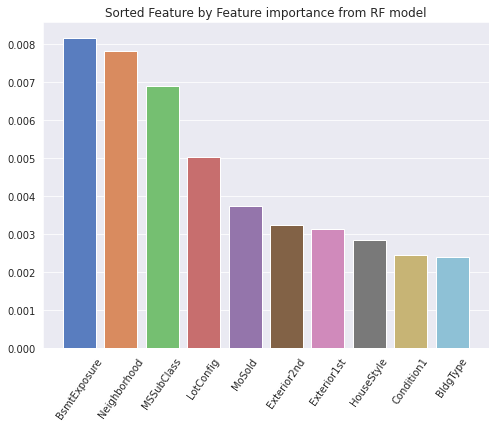

In [ ]:
result = permutation_importance(clf, X_train_cat, y_train, n_repeats=10,
                                 random_state=0)

plt.figure(figsize = [8,6])
top_k = 10
#sns.barplot(x=imprt_feats[:top_k], y= np.sort(clf.feature_importances_)[::-1][:top_k])
imprt_feats = X_train_cat.columns[np.argsort(result.importances_mean)[::-1]]
scores = np.sort(result.importances_mean)[::-1]
sns.barplot(x=imprt_feats[:top_k], y= scores[:top_k])
plt.xticks(rotation = 55)
plt.title("Sorted Feature by Feature importance from RF model")
plt.plot()

In [ ]:
best_ones

['OverallQual',
 'TotalSF',
 'ExterQual',
 'YearBuilt',
 'OverallScore',
 'KitchenQual',
 'GarageCars',
 'BsmtQual',
 'FireplaceGrade',
 'BsmtExposure',
 'Neighborhood',
 'MSSubClass',
 'LotConfig',
 'BldgType',
 'Condition1',
 'HouseStyle',
 'MiscFeature']

[('BsmtExposure', 0.01283072553819794), ('Neighborhood', 0.010484573186338619)]
[('MSSubClass', 0.00846699762270794), ('LotConfig', 0.005559787752684053)]
[('BldgType', 0.00613149879801308), ('Condition1', 0.006069129831787047)]
[('HouseStyle', 0.007804334809809299), ('MiscFeature', 0.00515849067389461)]


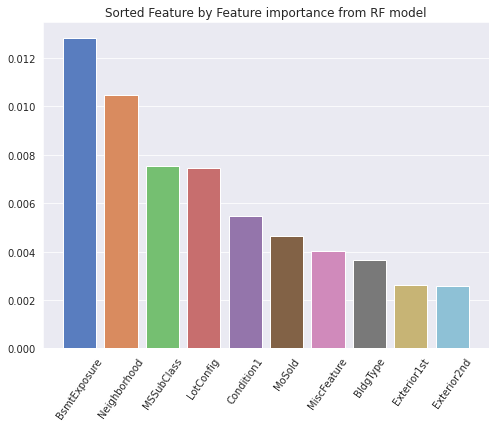

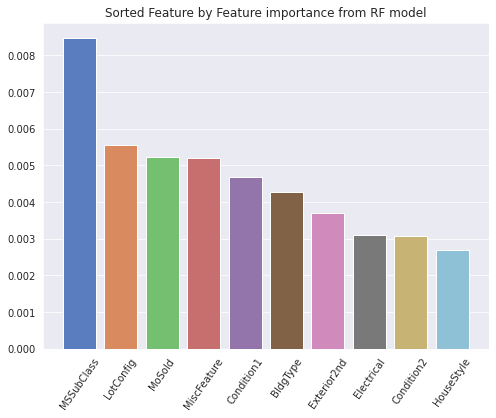

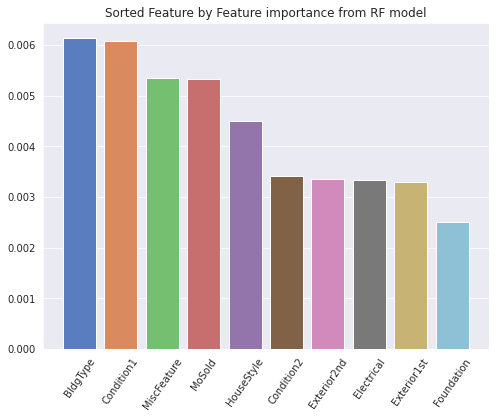

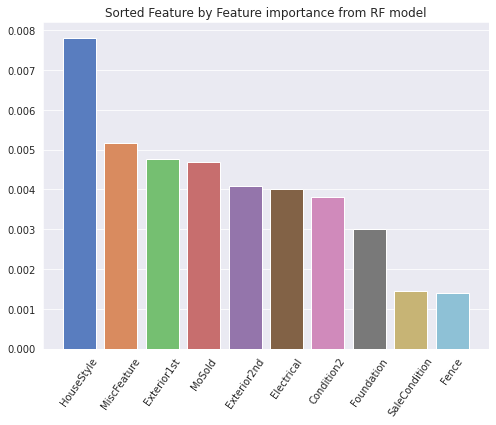

In [ ]:
mod_X_train = X_train_cat.copy()
mod_y_train = y_train.copy()
for i in range(4):
  clf = RandomForestRegressor(max_depth=3, min_samples_split = 30, random_state=0)
  clf.fit(mod_X_train, mod_y_train)
  result = permutation_importance(clf, mod_X_train, mod_y_train, n_repeats=10,
                                  random_state=0)

  plt.figure(figsize = [8,6])
  top_k = 10
  #sns.barplot(x=imprt_feats[:top_k], y= np.sort(clf.feature_importances_)[::-1][:top_k])
  imprt_feats = mod_X_train.columns[np.argsort(result.importances_mean)[::-1]]
  scores = np.sort(result.importances_mean)[::-1]
  sns.barplot(x=imprt_feats[:top_k], y= scores[:top_k])
  plt.xticks(rotation = 55)
  plt.title("Sorted Feature by Feature importance from RF model")
  plt.plot()

  to_drop = imprt_feats[:2].tolist()
  best_ones += to_drop
  print(list(zip(to_drop, scores[:2])))
  mod_X_train.drop(columns = to_drop, inplace= True)
  mod_y_train.drop(columns = to_drop, inplace= True)

In [ ]:
X_train_cat[best_ones[-8:]].corr() #not best for cate, but serves to filter out duplicate features

,BsmtExposure,Neighborhood,MSSubClass,LotConfig,BldgType,Condition1,HouseStyle,MiscFeature
BsmtExposure,1.000000,0.079929,-0.043132,-0.021734,-0.029770,-0.024618,-0.038356,0.009321
Neighborhood,0.079929,1.000000,-0.030120,-0.056786,0.013439,-0.020230,0.044105,-0.028746
MSSubClass,-0.043132,-0.030120,1.000000,-0.063900,-0.415911,0.021152,0.404924,0.025718
LotConfig,-0.021734,-0.056786,-0.063900,1.000000,0.111606,0.002526,-0.022796,0.003331
BldgType,-0.029770,0.013439,-0.415911,0.111606,1.000000,-0.017672,0.087222,-0.064608
Condition1,-0.024618,-0.020230,0.021152,0.002526,-0.017672,1.000000,0.107378,0.016274
HouseStyle,-0.038356,0.044105,0.404924,-0.022796,0.087222,0.107378,1.000000,-0.017740
MiscFeature,0.009321,-0.028746,0.025718,0.003331,-0.064608,0.016274,-0.017740,1.000000


In [ ]:
# print(len(best_ones))
# if "Exterior1st" in best_ones:
#   best_ones.remove("Exterior1st") 
# len(best_ones)

#### Final train_test_split

In [ ]:
best_ones = best_ones[:8] + ["PoolGrade"] + best_ones[8:]

In [ ]:
train_num = traindf[set(num_cols).intersection(best_ones)]
if len(set(num_cols).intersection(best_ones)) != len(best_ones):
  train_cat = traindf[set(cate_cols).intersection(best_ones)]
  #train_cat = pd.get_dummies(train_cat)
  for col in train_cat.columns:
    train_cat[col] = train_cat[col].astype('category').cat.codes
  print(f"category data has shape {train_cat.shape}")
# Join categorical and numerical features
train = pd.concat([train_num, train_cat], axis = 1)
train.BsmtQual[train.BsmtQual == "None"] = 0
train.BsmtQual = train.BsmtQual.astype(int)
assert np.object not in train.dtypes.tolist() #ensure no string columns
print("New number of features : " + str(train.shape[1]))
y = traindf["New_Price"]

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

category data has shape (1456, 8)
New number of features : 17
X_train : (1019, 17)
X_test : (437, 17)
y_train : (1019,)
y_test : (437,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


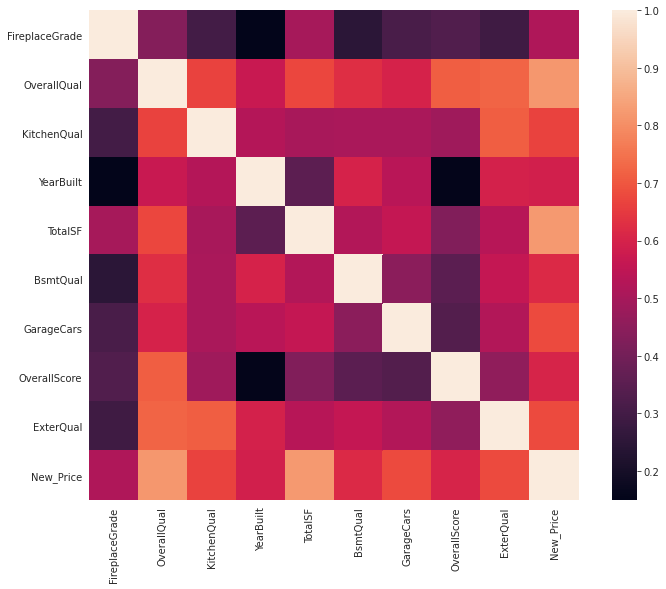

In [ ]:
corrmat = pd.concat([train_num, traindf["New_Price"]], axis = 1).corr()
plt.figure(figsize=(12,9))
sns.heatmap(corrmat, vmax=1, square=True)
plt.show()

#### Models

In [ ]:
# current selected best set of features
'''
['OverallQual', 'TotalSF','ExterQual','YearBuilt', 'OverallScore','KitchenQual',
 'GarageCars','BsmtQual','FireplaceGrade','BsmtExposure','Neighborhood',
 'MSSubClass','LotConfig','BldgType','Condition1','HouseStyle','MiscFeature']
'''
best_ones

['OverallQual',
 'TotalSF',
 'ExterQual',
 'YearBuilt',
 'OverallScore',
 'KitchenQual',
 'GarageCars',
 'BsmtQual',
 'FireplaceGrade',
 'BsmtExposure',
 'Neighborhood',
 'MSSubClass',
 'LotConfig',
 'BldgType',
 'Condition1',
 'HouseStyle',
 'MiscFeature']

In [ ]:
# Current best model score

clf = RandomForestRegressor(n_estimators = 400, max_depth=30, min_samples_split = 5, 
                            bootstrap = True, min_samples_leaf = 1, 
                            max_features = "sqrt", random_state=0)

clf.fit(X_train, y_train)
pred = clf.predict(X_test)
np.sqrt(np.mean((pred - y_test) ** 2))

0.12480835384595479

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [ ]:
#Validation function
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

#### model (alt)

In [ ]:
from sklearn.linear_model import Ridge, Lasso

In [ ]:
rgr_lasso = Lasso(alpha =0.001, random_state=1)
ENet = ElasticNet(alpha=1e-3, l1_ratio=.95, random_state=3)
KRidge = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)


In [ ]:
KRidge = KernelRidge(alpha=100, kernel='polynomial', degree=2)
model = KRidge
model.fit(X_train, y_train)
pred = model.predict(X_test)
print(model_name[i], ": ", np.sqrt(np.mean((pred - y_test) ** 2)))

model_lgb :  0.1274532990397022


In [ ]:
model_name = ["rgr_lasso", "ENet", "KRidge", "GBr", "model_xgb", "model_lgb"]
for i,model in enumerate([rgr_lasso, ENet, KRidge, GBr, model_xgb, model_lgb]:
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  print(model_name[i], ": ", np.sqrt(np.mean((pred - y_test) ** 2)))

rgr_lasso :  0.1303943207132662
ENet :  0.13079743654937762
KRidge :  0.12931528133162887


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.73771e-17): result may not be accurate.
  overwrite_a=False)


GBr :  0.12862145642587938
model_xgb :  0.12308868310541086
model_lgb :  0.1270020991393302


In [ ]:
KRR.fit(X_train, y_train)
pred = KRR.predict(X_test)
np.sqrt(np.mean((pred - y_test) ** 2))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.73771e-17): result may not be accurate.
  overwrite_a=False)


0.12931528133162887

In [ ]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # clone original models, store them in models; and leave the ones to update in models_
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [ ]:
averaged_models = AveragingModels(models = (ENet, GBr, KRidge, rgr_lasso))
averaged_models.fit(X_train, y_train)
pred = averaged_models.predict(X_test)
np.sqrt(np.mean((pred - y_test) ** 2))

0.12116449057369127

In [ ]:
nfrom sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import StackingRegressor

estimators = [
    ('lr', RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1])),
    ('svr', LinearSVR(random_state=42)),
    ('kridge', KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)),
    ('xgb', xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)),
    ('lgb', lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11))]

stack_reg = StackingRegressor(
    estimators=estimators,
    final_estimator = Lasso(alpha =0.001, random_state=1)) #RandomForestRegressor(n_estimators=10,
                                          #random_state=42))


stack_reg.fit(X_train, y_train)
pred = stack_reg.predict(X_test)
np.sqrt(np.mean((pred - y_test) ** 2))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.73771e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/li

0.12102273993483081

In [ ]:
from sklearn.linear_model import RidgeCV
from sklearn.svm import LinearSVR
from sklearn.ensemble import StackingRegressor

estimators = [
    ('lr', RidgeCV()),
    ('svr', LinearSVR(random_state=42)),
    ('kridge', KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)),
    ('xgb', xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)),
    ('lgb', lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11))]

stack_reg = StackingRegressor(
    estimators=estimators,
    final_estimator = Lasso(alpha =0.001, random_state=1)) #RandomForestRegressor(n_estimators=10,
                                          #random_state=42))


stack_reg.fit(X_train, y_train)
pred = stack_reg.predict(X_test)
np.sqrt(np.mean((pred - y_test) ** 2))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_ridge.py:188: LinAlgWarning: Ill-conditioned matrix (rcond=3.73771e-17): result may not be accurate.
  overwrite_a=False)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/li

0.1288765303933147

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models] # ea list stores the kfold versions of same base model
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [ ]:
rgr_lasso = Lasso(alpha =0.001, random_state=1)
StackingAveragedModels = StackingAveragedModels([ENet, KRidge, GBr, model_xgb, model_lgb], rgr_lasso, 6)

In [ ]:
stacked_averaged_models.fit(X_train.values, y_train.values)
pred = stacked_averaged_models.predict(X_test.values)
np.sqrt(np.mean((pred - y_test) ** 2))

0.11991761498141539

In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

stacked_averaged_models.fit(X_train.values, y_train.values)
stacked_train_pred = stacked_averaged_models.predict(X_train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test.values)) + 1
print(rmsle(y_train, stacked_train_pred))

0.09451427643702665


In [ ]:
stacked_pred = stacked_averaged_models.predict(X_test.values)
xgb_pred = model_xgb.predict(X_test)
lgb_pred = model_lgb.predict(X_test)

In [ ]:
ensemble = stacked_pred*0.8 + xgb_pred*0.1 + lgb_pred*0.1
np.sqrt(np.mean((ensemble - y_test) ** 2))

0.11978342924632433

In [ ]:
for col in X_train.columns:
  if col not in testdf.columns:
    print(col)

FireplaceGrade
TotalSF
OverallScore


In [ ]:
for col in na_info.index:
  if na_info.loc[col].Count > 0:
    if col in ["GarageYrBlt", "MasVnrArea", "BsmtQual"]:
      testdf[col].fillna(0, inplace = True)
    
    elif col == "LotFrontage":
      #As lot size should be similar for all houses in the same neighborhood, we will use the median for substitute for
      testdf["LotFrontage"] = testdf.groupby("Neighborhood")["LotFrontage"].transform(\
      lambda x: x.fillna(x.median()))
    elif col in ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'TotalBsmtSF']:
      testdf[col] = testdf[col].fillna(testdf[col].mode()[0])
    
    elif col == "Functional":
      testdf["Functional"] = testdf["Functional"].fillna("Typ")

    else:
      testdf[col].fillna("None", inplace = True)

sum(testdf.isnull().sum()) # should be 0 if all imputed

0

In [ ]:
testdf["FireplaceGrade"] = testdf["Fireplaces"] * testdf["FireplaceQu"]
testdf["TotalSF"] = testdf["1stFlrSF"] + testdf["2ndFlrSF"] + testdf["TotalBsmtSF"]
testdf["OverallScore"] = testdf["OverallQual"] * testdf["OverallCond"]

In [ ]:
# # Cate -> ordinal for those that have inherent order meanings
# poor_to_excellent = {"None" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5}

# # method 1 -> NA as lowest
# testdf = testdf.replace({"Alley" : {'None': 0, "Grvl" : 1, "Pave" : 2},
#                        "BsmtCond" : poor_to_excellent,
#                        "BsmtExposure" : {"None" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
#                        "BsmtFinType1" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
#                                          "ALQ" : 5, "GLQ" : 6},
#                        "BsmtFinType2" : {"None" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
#                                          "ALQ" : 5, "GLQ" : 6},
#                        "BsmtQual" : poor_to_excellent,
#                        "ExterCond" : poor_to_excellent,
#                        "ExterQual" : poor_to_excellent,
#                        "FireplaceQu" : poor_to_excellent,
#                        "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
#                                        "Min2" : 6, "Min1" : 7, "Typ" : 8},
#                        "GarageCond" : poor_to_excellent,
#                        "GarageQual" : poor_to_excellent,
#                        "HeatingQC" : poor_to_excellent,
#                        "KitchenQual" : poor_to_excellent,
#                        "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
#                        "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
#                        "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
#                        "PoolQC" : {"None" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
#                        "Street" : {"Grvl" : 1, "Pave" : 2},
#                        "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
#                      )

# # Drop levels in feature to simplify
# tri_for_ten = {1 : 1, 2 : 1, 3 : 1, # bad
#  4 : 2, 5 : 2, 6 : 2, # average
# 7 : 3, 8 : 3, 9 : 3, 10 : 3} # good
# avg_gd_bad_five = {1 : 1, # bad 
#                    2 : 2, 3 : 2, # average
#                    4 : 3, 5 : 3} # good

# testdf["S_OverallQual"] = testdf.OverallQual.replace(tri_for_ten)
# testdf["S_OverallCond"] = testdf.OverallCond.replace(tri_for_ten)
# testdf["S_PoolQC"] = testdf.PoolQC.replace({1 : 1, 2 : 1, # average
#                                              3 : 2, 4 : 2 # good
#                                             })
# testdf["S_GarageCond"] = testdf.GarageCond.replace(avg_gd_bad_five)
# testdf["S_GarageQual"] = testdf.GarageQual.replace(avg_gd_bad_five)
# testdf["S_FireplaceQu"] = testdf.FireplaceQu.replace(avg_gd_bad_five)
# testdf["S_FireplaceQu"] = testdf.FireplaceQu.replace(avg_gd_bad_five)
# testdf["S_Functional"] = testdf.Functional.replace({1 : 1, 2 : 1, # bad
#                                                      3 : 2, 4 : 2, # major issue
#                                                      5 : 3, 6 : 3, 7 : 3, # minor issue
#                                                      8 : 4 # typical
#                                                     })
# testdf["S_KitchenQual"] = testdf.KitchenQual.replace(avg_gd_bad_five)
# testdf["S_HeatingQC"] = testdf.HeatingQC.replace(avg_gd_bad_five)
# testdf["S_BsmtFinType1"] = testdf.BsmtFinType1.replace({1 : 1, # unfinished
#                                                          2 : 1, 3 : 1, # rec room
#                                                          4 : 2, 5 : 2, 6 : 2 # living quarters
#                                                         })
# testdf["S_BsmtFinType2"] = testdf.BsmtFinType2.replace({1 : 1, # unfinished
#                                                          2 : 1, 3 : 1, # rec room
#                                                          4 : 2, 5 : 2, 6 : 2 # living quarters
#                                                         })
# testdf["S_BsmtCond"] = testdf.BsmtCond.replace(avg_gd_bad_five)
# testdf["S_BsmtQual"] = testdf.BsmtQual.replace(avg_gd_bad_five)
# testdf["S_ExterCond"] = testdf.ExterCond.replace(avg_gd_bad_five)
# testdf["S_ExterQual"] = testdf.ExterQual.replace(avg_gd_bad_five)


# # Combine for "department" Grade
# # ============ Original ============ #
# # Overall quality of the house
# testdf["OverallScore"] = testdf["OverallQual"] * testdf["OverallCond"]

# # Overall quality of the garage
# testdf["GarageScore"] = testdf["GarageQual"] * testdf["GarageCond"]
# # Overall quality of the exterior
# testdf["ExterGrade"] = testdf["ExterQual"] * testdf["ExterCond"]
# # Overall kitchen Grade
# testdf["KitchenGrade"] = testdf["KitchenAbvGr"] * testdf["KitchenQual"]
# # Overall fireplace Grade
# testdf["FireplaceGrade"] = testdf["Fireplaces"] * testdf["FireplaceQu"]
# # Overall garage Grade
# testdf["GarageGrade"] = testdf["GarageArea"] * testdf["GarageQual"]
# # Overall pool Grade
# testdf["PoolGrade"] = testdf["PoolArea"] * testdf["PoolQC"]

# cols = ["OverallScore", "GarageScore", "ExterGrade", "KitchenGrade", "FireplaceGrade", "GarageGrade", "PoolGrade"]
# testdf[cols] = scaler.fit_transform(testdf[cols])
# # ============ Simplified ============ #
# # Simplified overall quality of the house
# testdf["S_OverallScore"] = testdf["S_OverallQual"] * testdf["S_OverallCond"]

# # Simplified overall garage Grade
# testdf["S_GarageGrade"] = testdf["GarageArea"] * testdf["S_GarageQual"]
# # Simplified overall quality of the exterior
# testdf["S_ExterGrade"] = testdf["S_ExterQual"] * testdf["S_ExterCond"]
# # Simplified overall kitchen Grade
# testdf["S_KitchenGrade"] = testdf["KitchenAbvGr"] * testdf["S_KitchenQual"]
# # Simplified overall fireplace Grade
# testdf["S_FireplaceGrade"] = testdf["Fireplaces"] * testdf["S_FireplaceQu"]
# # Simplified overall pool Grade
# testdf["S_PoolGrade"] = testdf["PoolArea"] * testdf["S_PoolQC"]

# cols = ["S_OverallScore", "S_GarageGrade", "S_ExterGrade", "S_KitchenGrade", "S_FireplaceGrade", "S_GarageGrade", "S_PoolGrade"]
# testdf[cols] = scaler.fit_transform(testdf[cols])

# # ============ Custom ============ #
# # Total number of bathrooms
# testdf["TotalBath"] = testdf["BsmtFullBath"] + (0.5 * testdf["BsmtHalfBath"]) + \
# testdf["FullBath"] + (0.5 * testdf["HalfBath"])
# # Total SF for house (incl. basement)
# testdf["TotalSF"] = testdf["1stFlrSF"] + testdf["2ndFlrSF"] + testdf["TotalBsmtSF"]
# # Total SF for 1st + 2nd floors
# testdf["AllFlrsSF"] = testdf["1stFlrSF"] + testdf["2ndFlrSF"]
# # Total SF for porch
# testdf["AllPorchSF"] = testdf["OpenPorchSF"] + testdf["EnclosedPorch"] + \
# testdf["3SsnPorch"] + testdf["ScreenPorch"]
# # Has masonry veneer or not
# testdf["HasMasVnr"] = testdf.MasVnrType.replace({"BrkCmn" : 0, "BrkFace" : 1,
#                                                "Stone" : 2, "None" : 0})
# # House completed before sale or not
# testdf["PurchaseType"] = testdf.SaleCondition.replace({"Abnorml" : 1, "Alloca" : 2, "AdjLand" : 0, 
#                                                       "Family" : 1, "Normal" : 2, "Partial" : 3})




In [ ]:
Test_num = testdf[set(num_cols).intersection(best_ones)]
if len(set(num_cols).intersection(best_ones)) != len(best_ones):
  Test_cat = testdf[set(cate_cols).intersection(best_ones)]
  #Test_cat = pd.get_dummies(Test_cat)
  for col in Test_cat.columns:
    Test_cat[col] = Test_cat[col].astype('category').cat.codes
  print(f"category data has shape {Test_cat.shape}")

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities',
       ...
       'S_PoolGrade', 'TotalBath', 'AllSF', 'AllFlrsSF', 'AllPorchSF',
       'HasMasVnr', 'PurchaseType', 'New_Price', 'OverallGrade', 'ExterGrade'],
      dtype='object', length=119)

In [ ]:
Test_num['GarageCars'][Test_num['GarageCars'] == 'None'] = 0
Test_num['GarageCars'] = Test_num['GarageCars'].astype(int)
Test_num['GarageCars'].drop_duplicates()

Test_num['FireplaceGrade'][Test_num['FireplaceGrade'] == ''] = 0
Test_num['FireplaceGrade'].drop_duplicates()
Test_num['FireplaceGrade'] = Test_num['FireplaceGrade'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1021: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._where(~key, value, inplace=True)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.

0      1
2      2
15     3
53     0
115    4
368    5
Name: GarageCars, dtype: int64

In [ ]:
# Join categorical and numerical features
test = pd.concat([Test_num, Test_cat], axis = 1)
test.BsmtQual[test.BsmtQual == "None"] = 0
test.BsmtQual = test.BsmtQual.astype(int)
assert np.object not in test.dtypes.tolist() #ensure no string columns
print("New number of features : " + str(test.shape[1]))

New number of features : 17


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
test["FireplaceGrade"] = scaler.fit_transform(test["FireplaceGrade"][:, np.newaxis]).ravel()
test["OverallScore"] = scaler.fit_transform(test["OverallScore"][:, np.newaxis]).ravel()

In [ ]:
test_stacked_pred = stacked_averaged_models.predict(test.values)
test_xgb_pred = model_xgb.predict(test)
test_lgb_pred = model_lgb.predict(test)

In [ ]:
test_ensemble = test_stacked_pred*0.8 + test_xgb_pred*0.1 + test_lgb_pred*0.1

In [ ]:
test_ensemble = np.exp(test_ensemble)

In [ ]:
for col in train.describe():
  if train.describe()[col]["max"] == 1:
    print(col)

FireplaceGrade
OverallScore


In [ ]:
test_ensemble.shape #2919 - 1461 + 1

(1459,)

In [ ]:
np.arange(1461, 2920)

1459

In [ ]:
sub = pd.DataFrame()
sub['Id'] = np.arange(1461, 2920)
sub['SalePrice'] = test_ensemble
sub.to_csv('submission.csv',index=False)

In [ ]:
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Miscellaneous

In [ ]:
# no worrisome collinearity between features
r_inds, c_inds = np.where(corrmat > 0.8)
for r, c in zip(r_inds, c_inds):
  if r == c:
    continue
  if r > c: #skip duplicates
    continue
  print(corrmat.columns[r], corrmat.columns[c], round(corrmat.iloc[r, c], 4))

OverallQual New_Price 0.8192
AllSF New_Price 0.8173


In [ ]:
from sklearn.model_selection import KFold
def CV_folds(k = 5, train = X_train, y= y_train):
  cv_d = {}
  kf = KFold(n_splits=k, shuffle = True, random_state = 211)
  kf.get_n_splits(train)
  train_data = train.values
  i = 0
  for train_index, test_index in kf.split(train_data):
    X_train, X_test = train_data[train_index], train_data[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    cv_d[i] = X_train, X_test, y_train, y_test
    i += 1
  return cv_d

def rmse_cv_train(clf, X_train = X_train, y_train = y_train, k = 5):
  folds_d = CV_folds(k, X_train, y_train)
  rmse_l = []
  for i in range(k):
    x_tr, x_tst, y_tr, y_tst = folds_d[i]
    clf.fit(x_tr, y_tr)
    try:
      pred = clf.pred(x_tst)
    except:
      pred = clf.predict(x_tst)
    rmse_l.append(np.sqrt(np.mean((pred - y_test) ** 2)))
  return 

def rmse_cv_test(clf, X_test = X_test, y_test = y_test, k = 5):
  folds_d = CV_folds(k, X_test, y_test)
  rmse_l = []
  for i in range(k):
    x_tr, x_tst, y_tr, y_tst = folds_d[i]
    clf.fit(x_tr, y_tr)
    try:
      pred = clf.pred(x_tst)
    except:
      pred = clf.predict(x_tst)
    rmse_l.append(np.sqrt(np.mean((pred - y_test) ** 2)))
  return np.sqrt(np.mean((pred - y_test) ** 2))

In [ ]:
from sklearn.linear_model import ElasticNetCV
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 5000, cv = 10)

elasticNet.fit(X_train, y_train)

ElasticNetCV(alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03,
                     0.06, 0.1, 0.3, 0.6, 1, 3, 6],
             copy_X=True, cv=10, eps=0.001, fit_intercept=True,
             l1_ratio=[0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
             max_iter=5000, n_alphas=100, n_jobs=None, normalize=False,
             positive=False, precompute='auto', random_state=None,
             selection='cyclic', tol=0.0001, verbose=0)

In [ ]:
elasticNet.alpha_ #very small indicating that L2 is enough 

0.0003

In [ ]:
np.exp(elasticNet.predict(X_train)) - np.exp(y_train)

328    -53276.386126
1026   -10665.889920
843      9051.323925
994     16112.575092
1226     6455.079490
            ...     
765     -2069.578202
837     19824.724023
1219    21634.300846
560     42635.088692
685     28351.933237
Name: New_Price, Length: 1019, dtype: float64

In [ ]:
from sklearn.linear_model import ElasticNetCV
# 4* ElasticNet
elasticNet = ElasticNetCV(l1_ratio = [0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 
                                    0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 5000, cv = 10)

elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio = [ratio * .85, ratio * .9, ratio * .95, ratio, ratio * 1.05, ratio * 1.1, ratio * 1.15],
                          alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6], 
                          max_iter = 5000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) + 
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio = ratio,
                          alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, alpha * .9, 
                                    alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, 
                                    alpha * 1.35, alpha * 1.4], 
                          max_iter = 50000, cv = 10)
elasticNet.fit(X_train, y_train)
if (elasticNet.l1_ratio_ > 1):
    elasticNet.l1_ratio_ = 1    
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio :", ratio)
print("Best alpha :", alpha )

print("ElasticNet RMSE on Training set :", rmse_cv_train(elasticNet))
print("ElasticNet RMSE on Test set :", rmse_cv_test(elasticNet))
y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test, y_test_ela, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index = X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

Best l1_ratio : 0.1
Best alpha : 0.0003
Try again for more precision with l1_ratio centered around 0.1
Best l1_ratio : 0.085
Best alpha : 0.0006
Now try again for more precision on alpha, with l1_ratio fixed at 0.085 and alpha centered around 0.0006
Best l1_ratio : 0.085
Best alpha : 0.00047999999999999996


ValueError: ignored

In [ ]:
# Join categorical and numerical features
train = pd.concat([train_num, train_cat], axis = 1)
print("New number of features : " + str(train.shape[1]))
y = traindf["New_Price"]

# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

New number of features : 42
X_train : (1022, 42)
X_test : (438, 42)
y_train : (1022,)
y_test : (438,)


In [ ]:
# Standardize numerical features
scaler = MinMaxScaler()
X_train.loc[:, num_cols] = scaler.fit_transform(X_train.loc[:, num_cols])
X_test.loc[:, num_cols] = scaler.transform(X_test.loc[:, num_cols])

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [ ]:
X_train.head(2)

,KitchenQual,BsmtQual,FireplaceQu,TotalBath,YearRemodAdd,TotRmsAbvGrd,FullBath,YearBuilt,TotalBsmtSF,AllSF,OverallGrade,OverallQual,1stFlrSF,GarageCars,ExterGrade,ExterQual,MSSubClass,MSZoning,LandContour,LotConfig,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,Foundation,BsmtExposure,Heating,CentralAir,Electrical,GarageType,GarageFinish,Fence,MiscFeature,MoSold,SaleType,SaleCondition
64,0.666667,0.8,0.0,0.5,0.800000,0.500000,0.666667,0.905797,0.329694,0.368583,0.382022,0.666667,0.249827,0.5,0.352941,0.333333,SC60,RL,Lvl,Inside,CollgCr,Norm,Norm,1Fam,2Story,Gable,CompShg,VinylSd,VinylSd,BrkFace,PConc,No,GasA,Y,SBrkr,Attchd,RFn,GdPrv,None,Feb,WD,Normal
682,0.666667,0.8,0.8,0.2,0.783333,0.333333,0.333333,0.898551,0.402682,0.300535,0.325843,0.555556,0.330684,0.5,0.352941,0.333333,SC120,RL,HLS,Inside,ClearCr,Norm,Norm,1Fam,1Story,Gable,CompShg,Wd Sdng,Wd Sdng,None,PConc,1,GasA,Y,SBrkr,Attchd,Unf,None,None,Nov,WD,Normal


In [ ]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)


In [ ]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

ValueError: ignored

In [ ]:
# OPTIONAL

# Log transform of the skewed numerical features to lessen impact of outliers
# Inspired by Alexandru Papiu's script : https://www.kaggle.com/apapiu/house-prices-advanced-regression-techniques/regularized-linear-models
# As a general rule of thumb, a skewness with an absolute value > 0.5 is considered at least moderately skewed
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 0.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

0

In [ ]:
Others = traindf.columns[108:]

In [ ]:
custom = traindf.columns[96:102]
s_overalls = traindf.columns[102:108]

In [ ]:
s_cols = traindf.columns[81:96] #simplified recoded columns
s_cols = traindf.columns[81:96]

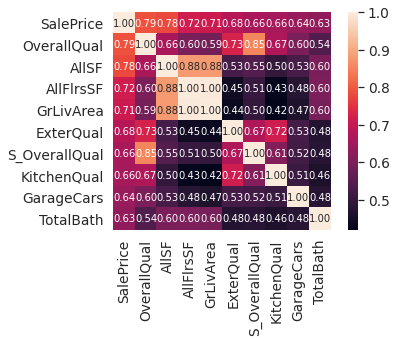

In [ ]:
#saleprice correlation matrix
corrmat = traindf.corr()
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(traindf[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


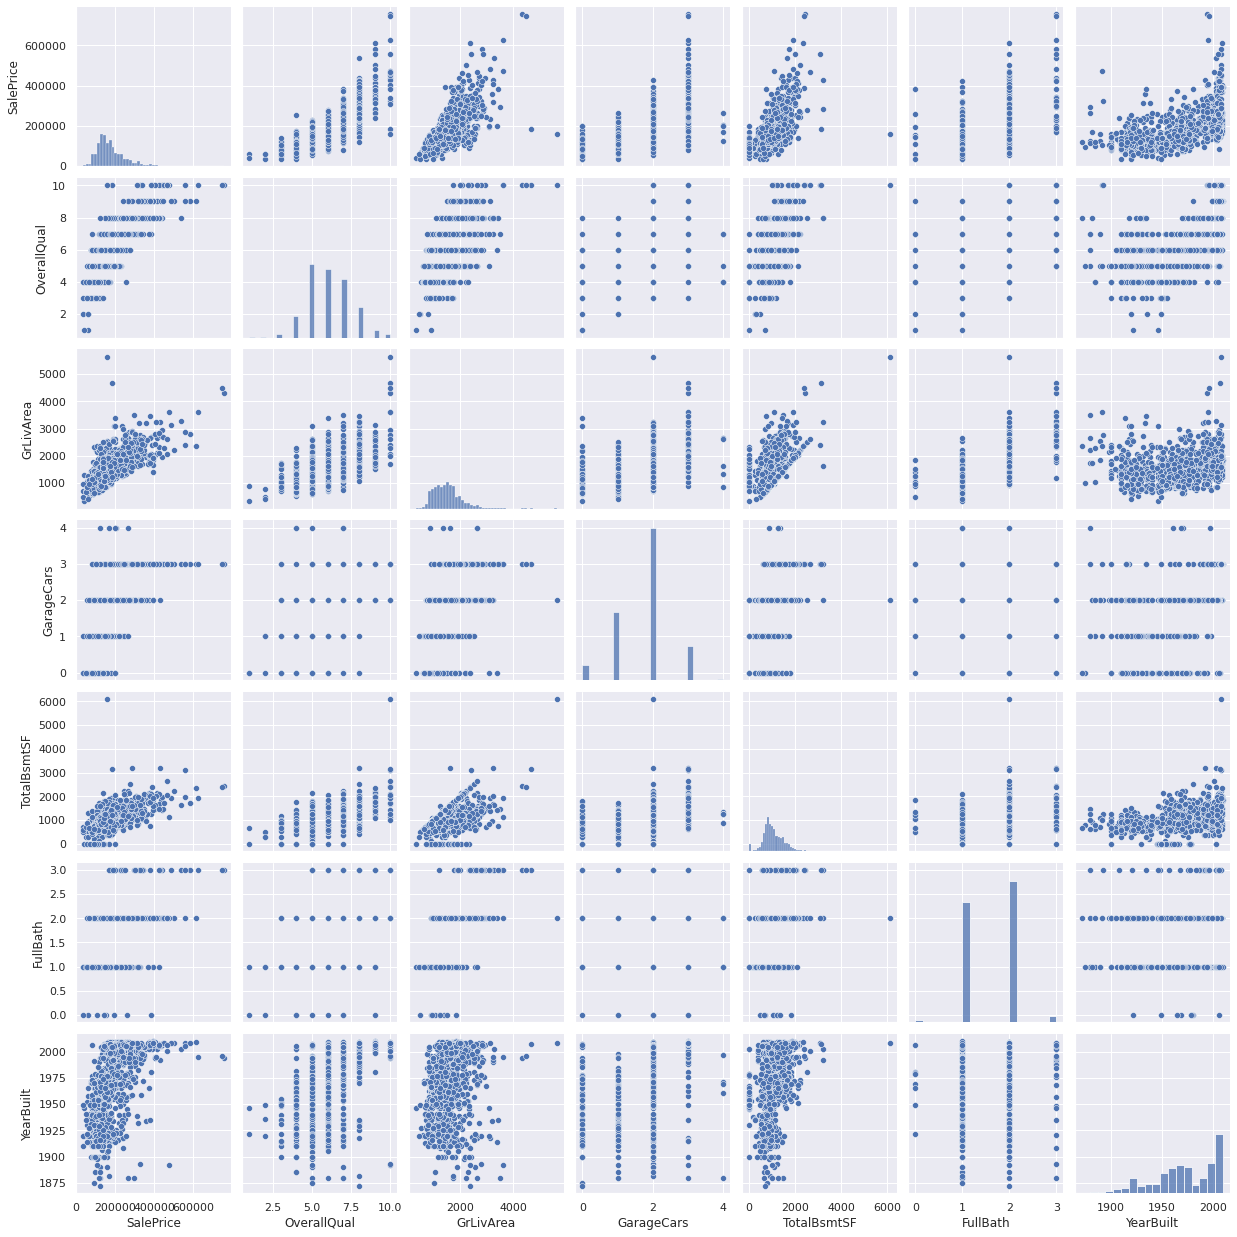

In [ ]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(traindf[cols], size = 2.5)
plt.show();